# Import Libraries and Load Data

In [86]:
import medmnist
from medmnist import INFO, BloodMNIST
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.feature import hog, graycomatrix, graycoprops
from skimage import io, color, exposure, filters

import cv2
from skimage import morphology, measure
from skimage.color import rgb2gray
import random
import pickle
import os

PICKLE_DIR = 'pickle'

In [5]:
# # Load the BloodMNIST dataset with high resolution for all splits
# # Run once then comment out and run pickle.load below

# train_data = BloodMNIST(split='train', download=True, as_rgb=True, size=224)
# val_data = BloodMNIST(split='val', download=True, as_rgb=True, size=224)
# test_data = BloodMNIST(split='test', download=True, as_rgb=True, size=224)

# # Save the dataset objects to disk
# with open('pickle/train_data.pkl', 'wb') as f:
#     pickle.dump(train_data, f)
# with open('pickle/val_data.pkl', 'wb') as f:
#     pickle.dump(val_data, f)
# with open('pickle/test_data.pkl', 'wb') as f:
#     pickle.dump(test_data, f)

Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz
Using downloaded and verified file: /Users/lowi33/.medmnist/bloodmnist_224.npz


In [6]:
# Load the dataset objects from disk
with open('pickle/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('pickle/val_data.pkl', 'rb') as f:
    val_data = pickle.load(f)
with open('pickle/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

# See Class Distribution

In [7]:
train_data

Dataset BloodMNIST of size 224 (bloodmnist_224)
    Number of datapoints: 11959
    Root location: /Users/lowi33/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    

In [8]:
# Get dataset information
blood_info = INFO['bloodmnist']
n_classes_blood = len(blood_info['label'])

# Get the class labels
class_labels_blood = blood_info['label']
class_labels_blood['3'] = 'Immature Granulocytes'

# Count the number of instances for each class in BloodMNIST
label_counts_blood = Counter([int(label) for _, label in train_data])

In [9]:
# Print the distribution of class labels for BloodMNIST
print("\nClass Label Distribution in BloodMNIST:")
for key, count in label_counts_blood.items():
    print(f"Class {key}: {count} instances")


Class Label Distribution in BloodMNIST:
Class 7: 1643 instances
Class 3: 2026 instances
Class 6: 2330 instances
Class 2: 1085 instances
Class 1: 2181 instances
Class 5: 993 instances
Class 0: 852 instances
Class 4: 849 instances


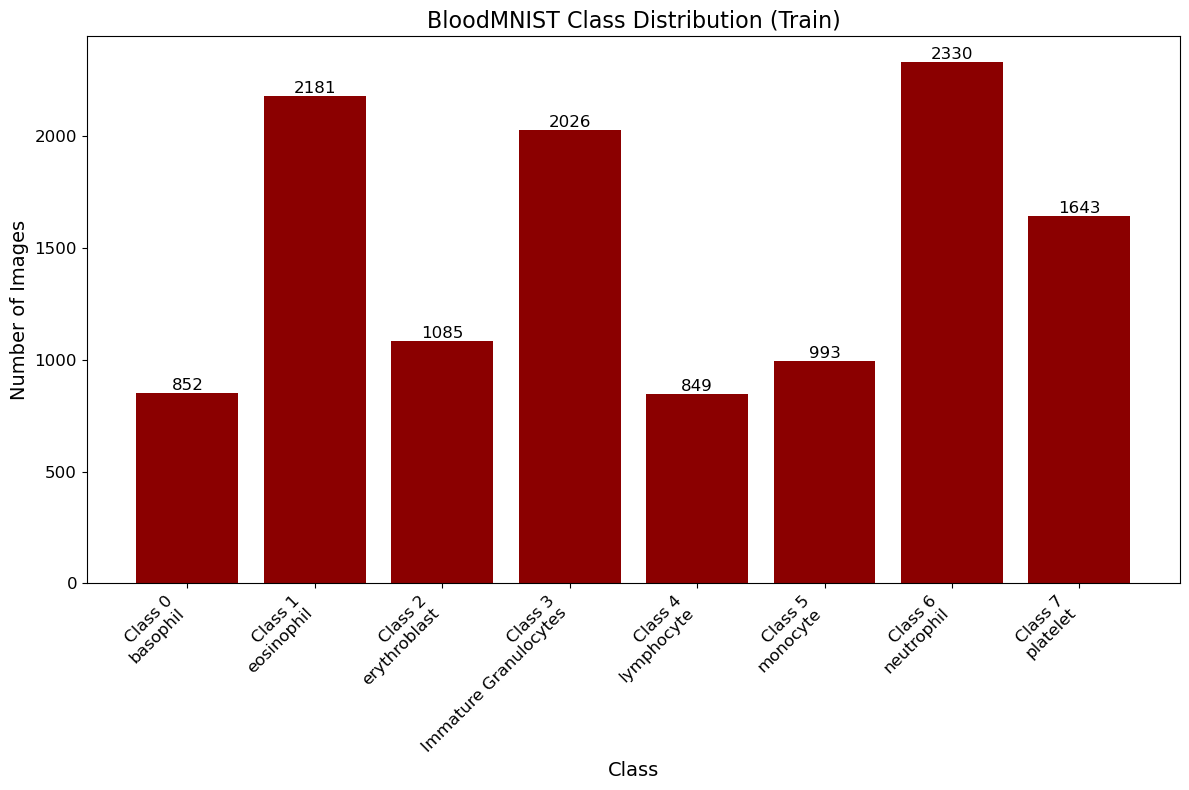

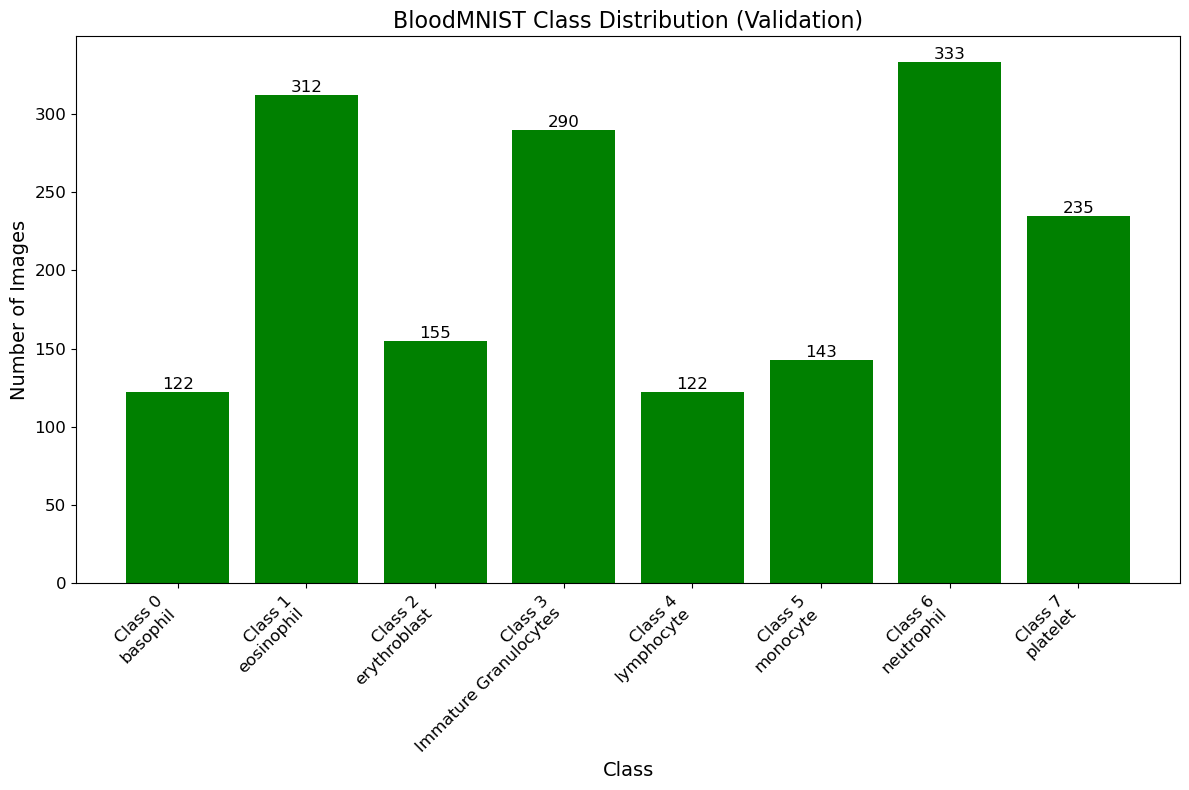

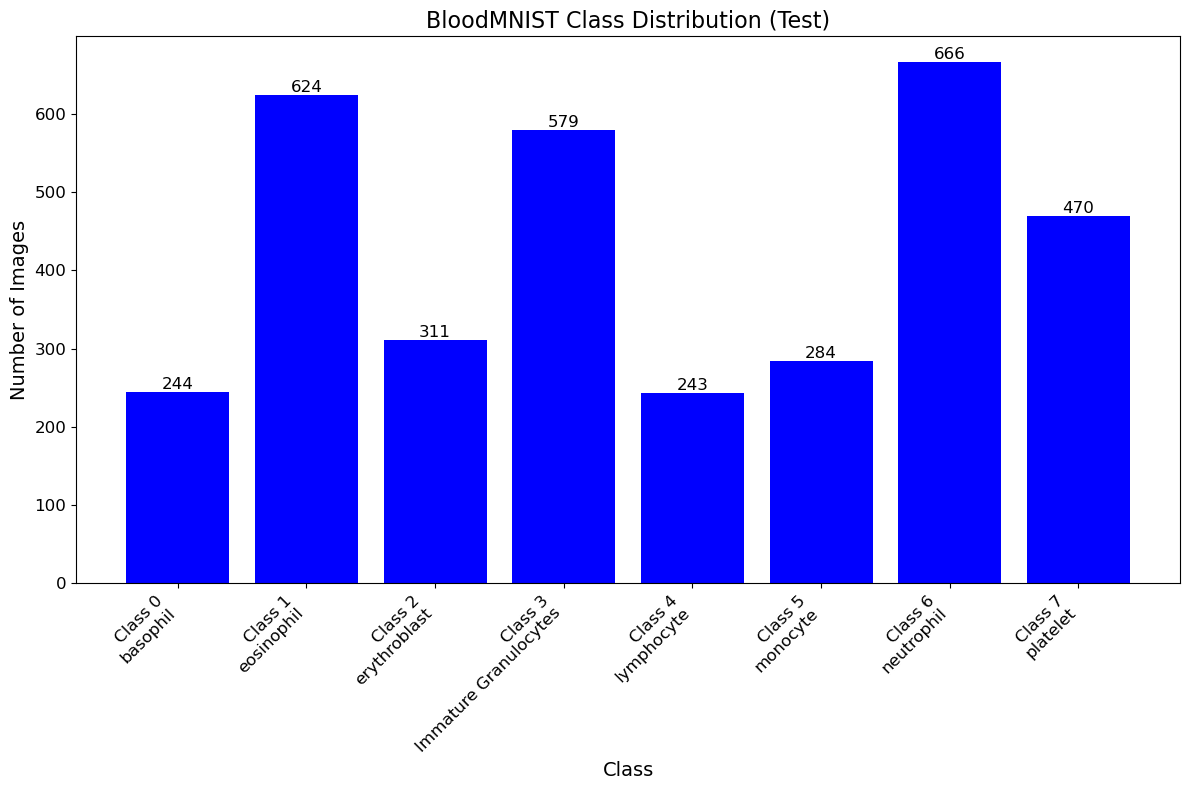

In [10]:
# Count the number of instances for each class in each split
label_counts_train = Counter([int(label) for _, label in train_data])
label_counts_val = Counter([int(label) for _, label in val_data])
label_counts_test = Counter([int(label) for _, label in test_data])

def plot_class_distribution(label_counts, class_labels, title, color):
    classes = list(range(len(class_labels)))  # Ensure all classes are shown
    counts = [label_counts.get(i, 0) for i in classes]
    labels = [f"Class {i}\n{class_labels[str(i)]}" for i in classes]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(classes, counts, tick_label=labels, color=color)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of Images', fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)

    # Add data labels on top of each column
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

# Plot BloodMNIST class distribution
plot_class_distribution(label_counts_train, class_labels_blood, 'BloodMNIST Class Distribution (Train)', 'darkred')
plot_class_distribution(label_counts_val, class_labels_blood, 'BloodMNIST Class Distribution (Validation)', 'green')
plot_class_distribution(label_counts_test, class_labels_blood, 'BloodMNIST Class Distribution (Test)', 'blue')


# Image Preprocessing

- **Binary Thresholding**: Convert images to grayscale and apply a binary threshold to segment the target cells. This step helps in isolating the cells from the background by converting the image to black and white based on a threshold value.

- **Noise Reduction**: Remove small objects from the binary image to focus on the most significant parts of the image (i.e., target cells)

- **Component Labeling**: Label connected components in the binary image and retain the largest connected component, assuming it's the target cell. This step ensures that only the most relevant part of the image is considered.

- **Masking**: Apply the binary mask to the original image to highlight the target cells while suppressing the background and other irrelevant objects.

- **Data Conversion**: Use a class to convert the preprocessed data back to the original data format, which maintains compatibility with PyTorch methods while preserving the data structure for model training and evaluation.


In [11]:
def preprocess_image(image):
    # Convert to grayscale
    gray = rgb2gray(image)

    # Apply Gaussian blur to reduce noise and smooth the image
    blurred = cv2.GaussianBlur((gray * 255).astype(np.uint8), (5, 5), 0)

    # Apply a binary threshold to segment the target cells
    _, binary = cv2.threshold((gray * 255).astype(np.uint8), 128, 255, cv2.THRESH_BINARY_INV)

    # Remove small objects from the binary image
    cleaned = morphology.remove_small_objects(binary > 0, min_size=500)

    # Label the connected components
    labeled, num_labels = measure.label(cleaned, return_num=True, connectivity=2)

    # Keep the largest connected component (assuming it's the target cell)
    largest_component = morphology.remove_small_objects(labeled, min_size=500)

    # Mask the original image
    masked_image = image * np.dstack([largest_component > 0] * 3)

    return masked_image

In [12]:
def show_comparison(dataset, n_images=5):
    """Show comparison of original image to preprocessed image"""
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))

    for i in range(n_images):
        # Randomly select an image from the dataset
        idx = random.randint(0, len(dataset) - 1)
        img, label = dataset[idx]
        preprocessed_img = preprocess_image(np.array(img))

        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"Original Image - Class {int(label)}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(preprocessed_img)
        axes[i, 1].set_title(f"Preprocessed Image - Class {int(label)}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
def preprocess_dataset(dataset):
    """Pre-process the entire dataset"""
    preprocessed_data = []
    for img, label in dataset:
        preprocessed_img = preprocess_image(np.array(img))
        preprocessed_data.append((preprocessed_img, label))
    return preprocessed_data

In [16]:
# # Preprocess and overwrite the datasets
# # Run once then comment out and run pickle.load below

# train_data_preprocessed = preprocess_dataset(train_data)
# val_data_preprocessed = preprocess_dataset(val_data)
# test_data_preprocessed = preprocess_dataset(test_data)

# # Save the preprocessed datasets to disk
# with open('pickle/train_data_preprocessed.pkl', 'wb') as f:
#     pickle.dump(train_data_preprocessed, f)
# with open('pickle/val_data_preprocessed.pkl', 'wb') as f:
#     pickle.dump(val_data_preprocessed, f)
# with open('pickle/test_data_preprocessed.pkl', 'wb') as f:
#     pickle.dump(test_data_preprocessed, f)


/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_48018/251657343.py:18: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


In [17]:
with open('pickle/train_data_preprocessed.pkl', 'rb') as f:
    train_data_preprocessed = pickle.load(f)
with open('pickle/val_data_preprocessed.pkl', 'rb') as f:
    val_data_preprocessed = pickle.load(f)
with open('pickle/test_data_preprocessed.pkl', 'rb') as f:
    test_data_preprocessed = pickle.load(f)

In [18]:
# Convert preprocessed data back to original data format
class PreprocessedDataset:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        img, label = self.data[index]
        return img, label

    def __len__(self):
        return len(self.data)

In [21]:
# # Run once then comment out and run pickle.load below

# # Create dataset objects
# train_data_preprocessed = PreprocessedDataset(train_data_preprocessed)
# val_data_preprocessed = PreprocessedDataset(val_data_preprocessed)
# test_data_preprocessed = PreprocessedDataset(test_data_preprocessed)

# with open('pickle/train_data_preprocessed_dataset.pkl', 'wb') as f:
#     pickle.dump(train_data_preprocessed, f)
# with open('pickle/val_data_preprocessed_dataset.pkl', 'wb') as f:
#     pickle.dump(val_data_preprocessed, f)
# with open('pickle/test_data_preprocessed_dataset.pkl', 'wb') as f:
#     pickle.dump(test_data_preprocessed, f)

In [22]:
with open('pickle/train_data_preprocessed_dataset.pkl', 'rb') as f:
    train_data_preprocessed = pickle.load(f)
with open('pickle/val_data_preprocessed_dataset.pkl', 'rb') as f:
    val_data_preprocessed = pickle.load(f)
with open('pickle/test_data_preprocessed_dataset.pkl', 'rb') as f:
    test_data_preprocessed = pickle.load(f)

# Display Images

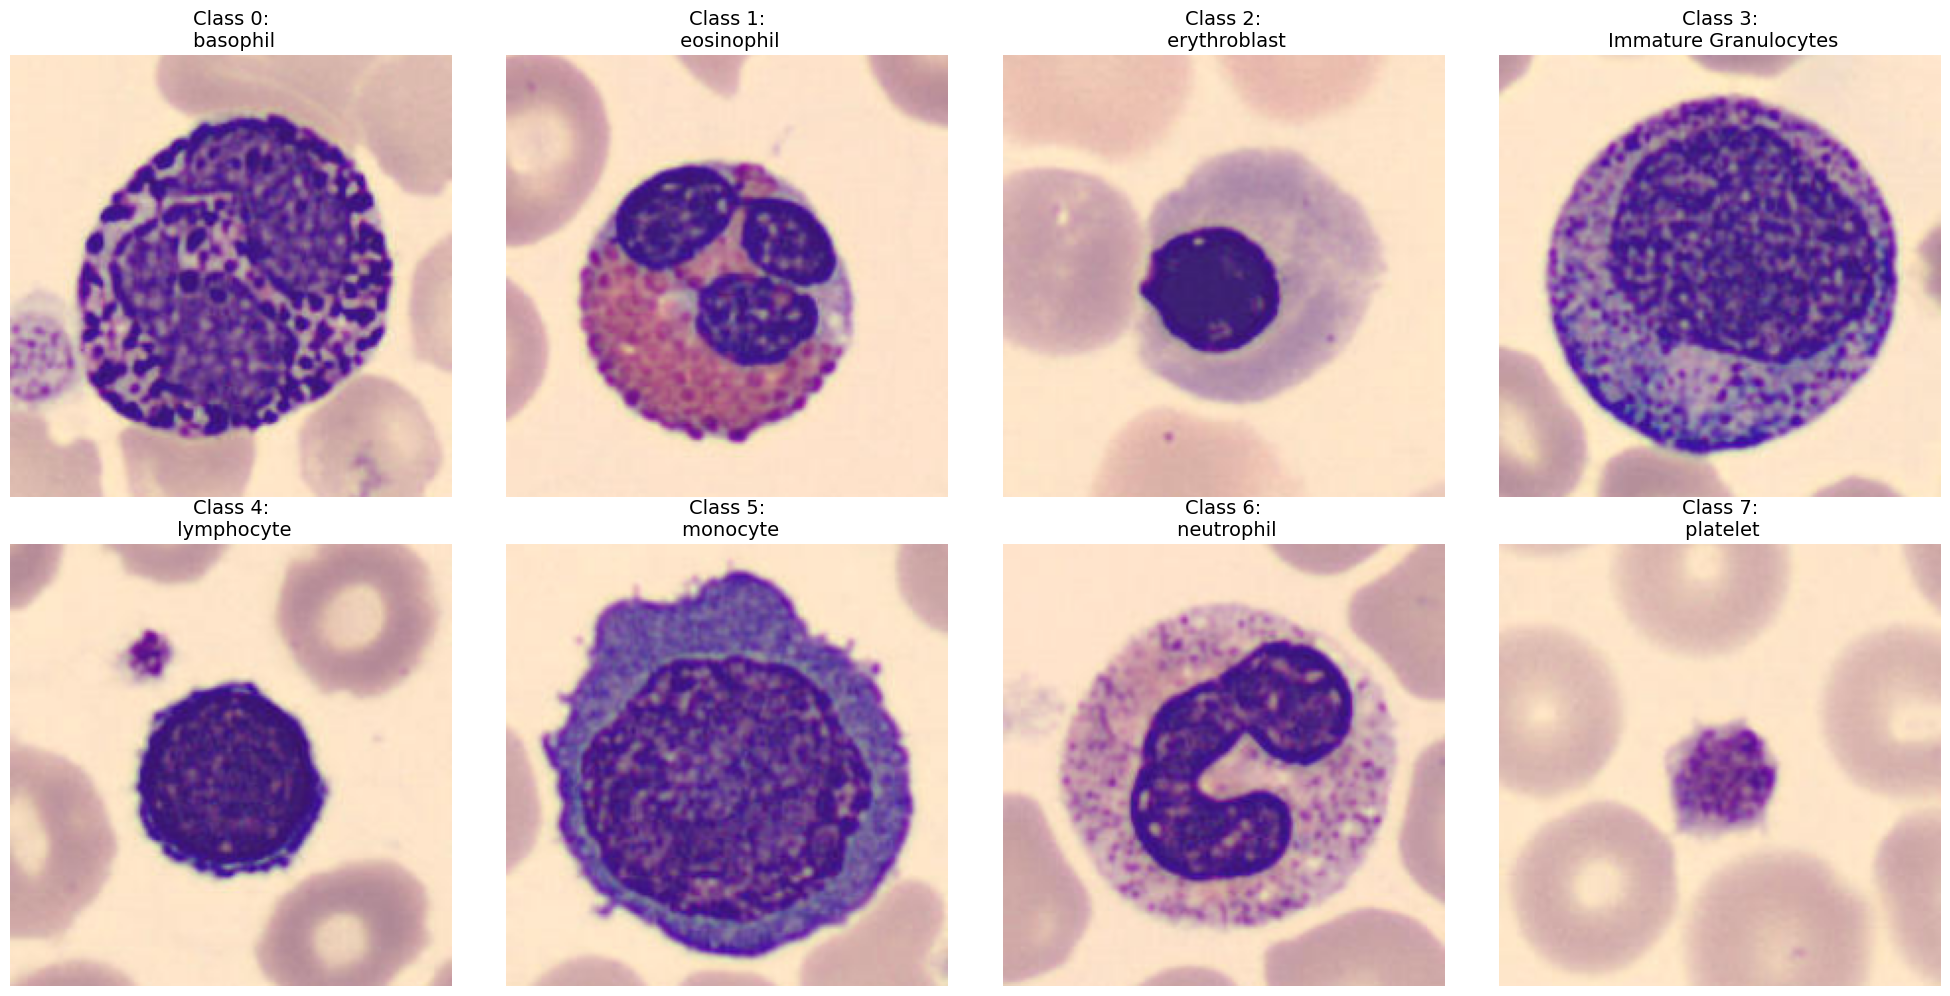

In [23]:
def show_one_image_per_class(dataset, n_classes, class_labels):
    """Randomly show one pre-processed image per class"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            axes[class_idx].imshow(random_img)
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show one example image from the preprocessed training dataset for each class
show_one_image_per_class(train_data, n_classes_blood, class_labels_blood)

/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_48018/251657343.py:18: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


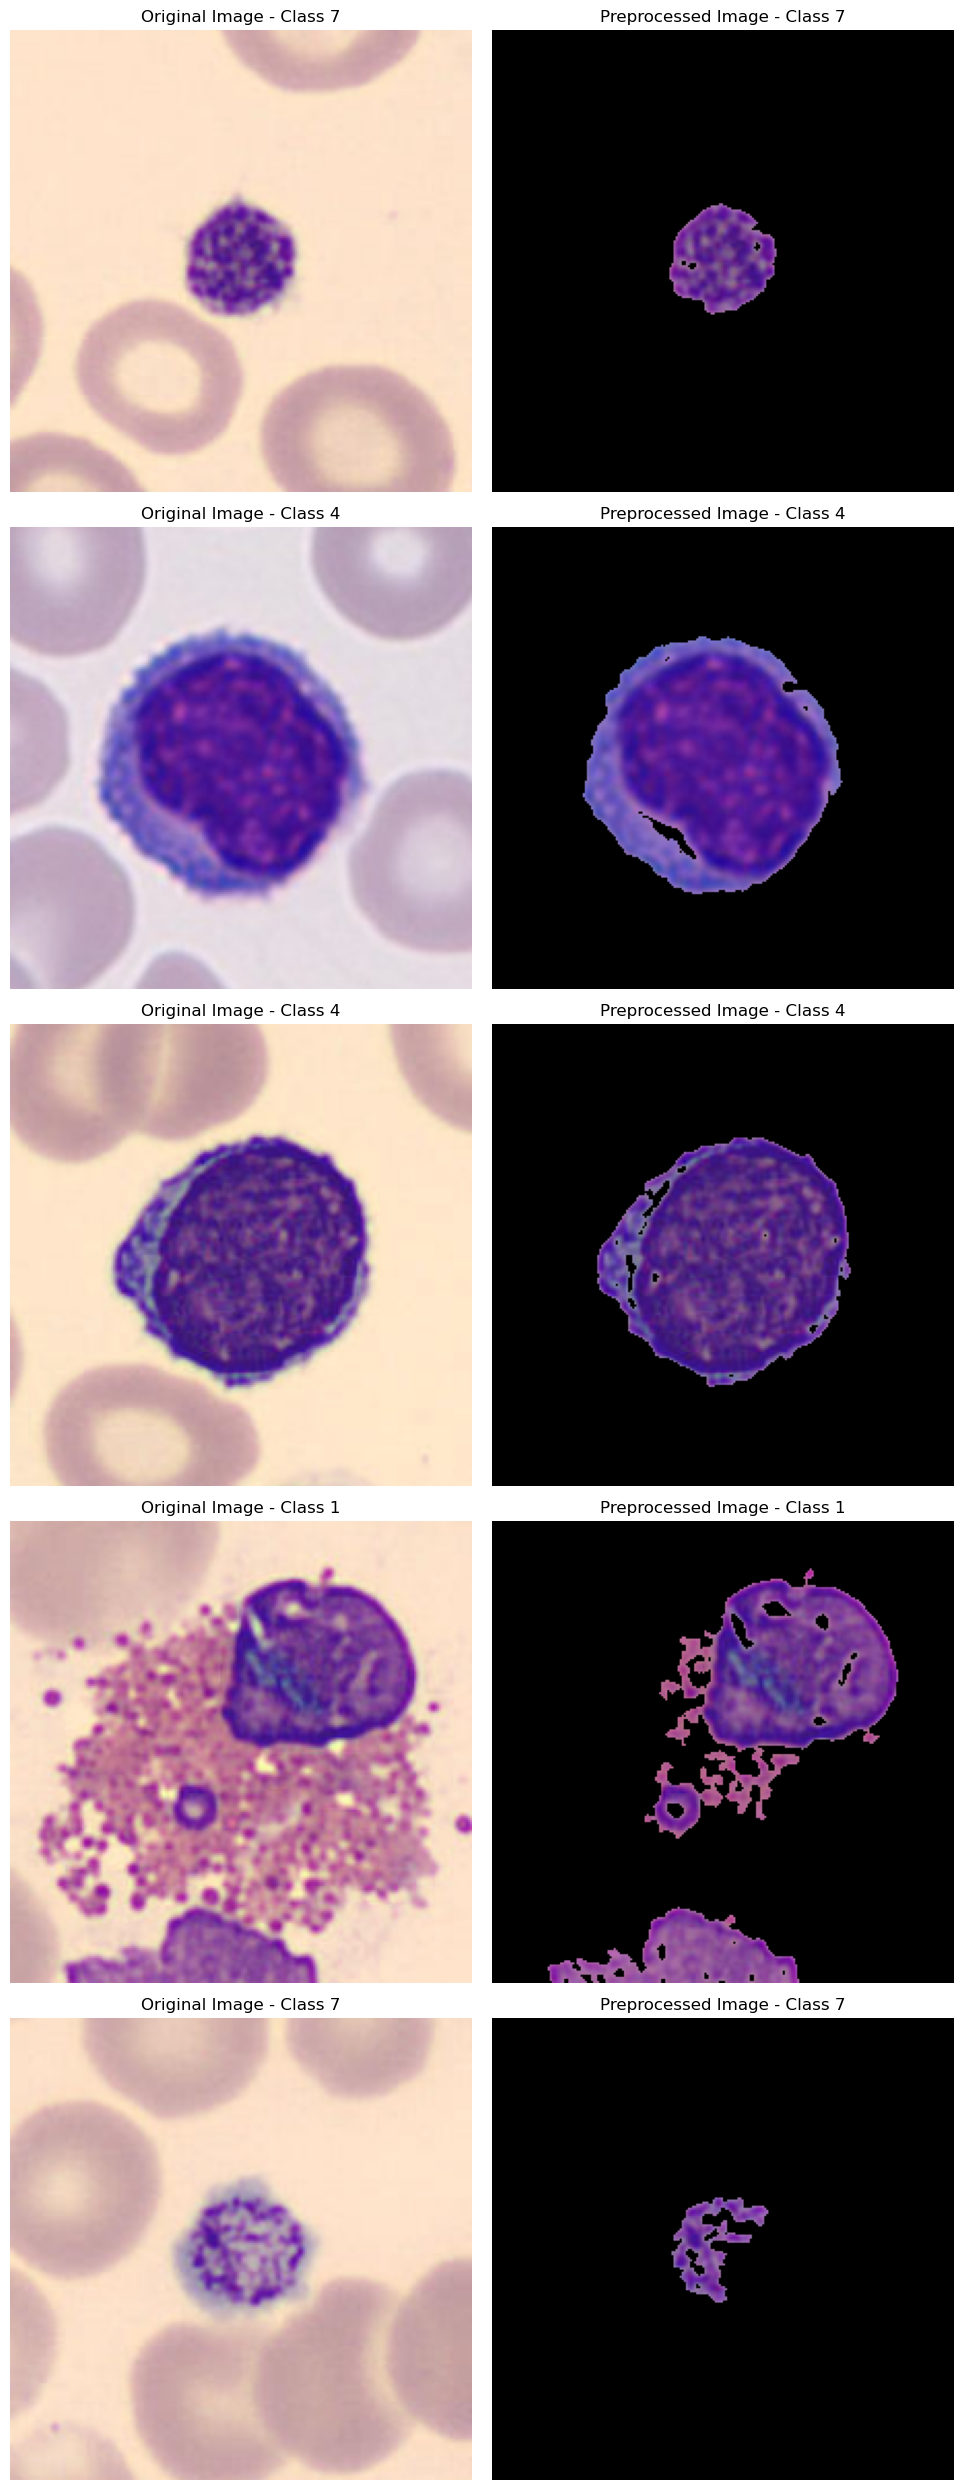

In [24]:
# Show comparison for 5 random images from the training dataset to showcase the pre-processing transformations
show_comparison(train_data, n_images=5)

# Feature Engineering
- Simple Feature: Edges
    - Edge detection can highlight the boundaries of cells, which is crucial for distinguishing between different types of blood cells based on their shape and size. Using edge detection algorithms can provide valuable information about cell morphology.

- Simple Feature: Color Histograms
    - Color histograms represent the distribution of colors in an image and can help differentiate between cell types based on color variations. This is particularly useful for identifying cell types like eosinophils and basophils, which have distinct color characteristics.

- Complex Feature: Texture Analysis
    - Texture analysis involves examining the surface characteristics of cells, which can be quantified using methods like Local Binary Patterns (LBP) or Gray Level Co-occurrence Matrix (GLCM). Texture features can provide deeper insights into the cell structure, helping to distinguish between similar looking cell types.


## Create Function for Feature Vector

In [25]:
def create_feature_vectors(dataset, feature_extractors):
    feature_vectors = []
    labels = []
    for img, label in dataset:
        features = []
        for extractor in feature_extractors:
            features.extend(extractor(np.array(img)))
        feature_vectors.append(features)
        labels.append(label)
    return np.array(feature_vectors), np.array(labels)


## Edge Detection

In [26]:
def extract_edge_features(image):
    edges = cv2.Canny((rgb2gray(image) * 255).astype(np.uint8), 100, 200)
    return edges.flatten()

/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_48018/251657343.py:18: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  largest_component = morphology.remove_small_objects(labeled, min_size=500)


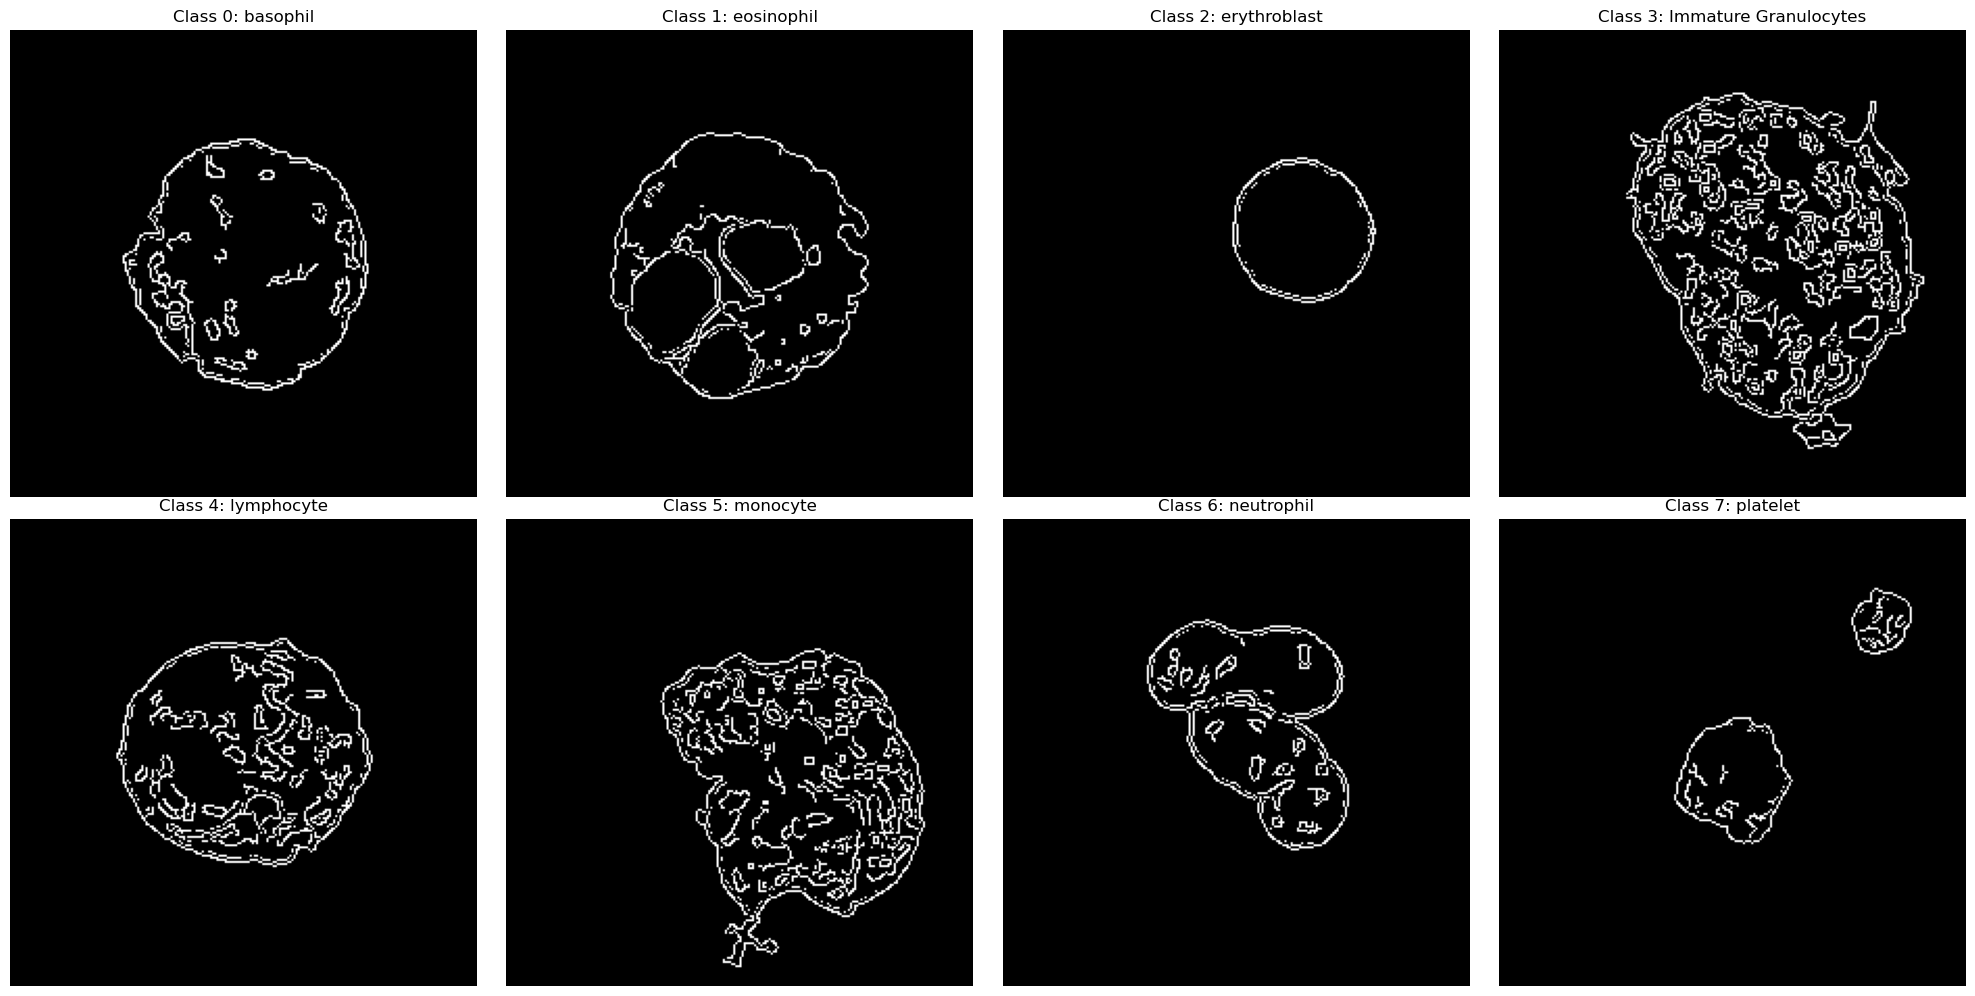

In [64]:
def show_edge_detection_per_class(dataset, n_classes, class_labels):
    """Show edge detection results for one example per class"""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        if len(class_images[label]) < 1:  # Store one example per class
            class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            img = class_images[class_idx][0]
            preprocessed_img = preprocess_image(np.array(img))
            edges = cv2.Canny((rgb2gray(img) * 255).astype(np.uint8), 100, 200)

            axes[class_idx].imshow(edges, cmap='gray')
            axes[class_idx].set_title(f"Class {class_idx}: {class_labels[str(class_idx)]}")
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show edge detection for one example from each class
show_edge_detection_per_class(train_data_preprocessed, n_classes_blood, class_labels_blood)


## Color Histograms

In [29]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    # Convert PIL Image to NumPy array
    image = np.array(image)

    # Convert the image to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Compute the color histogram
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])

    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()

    return hist

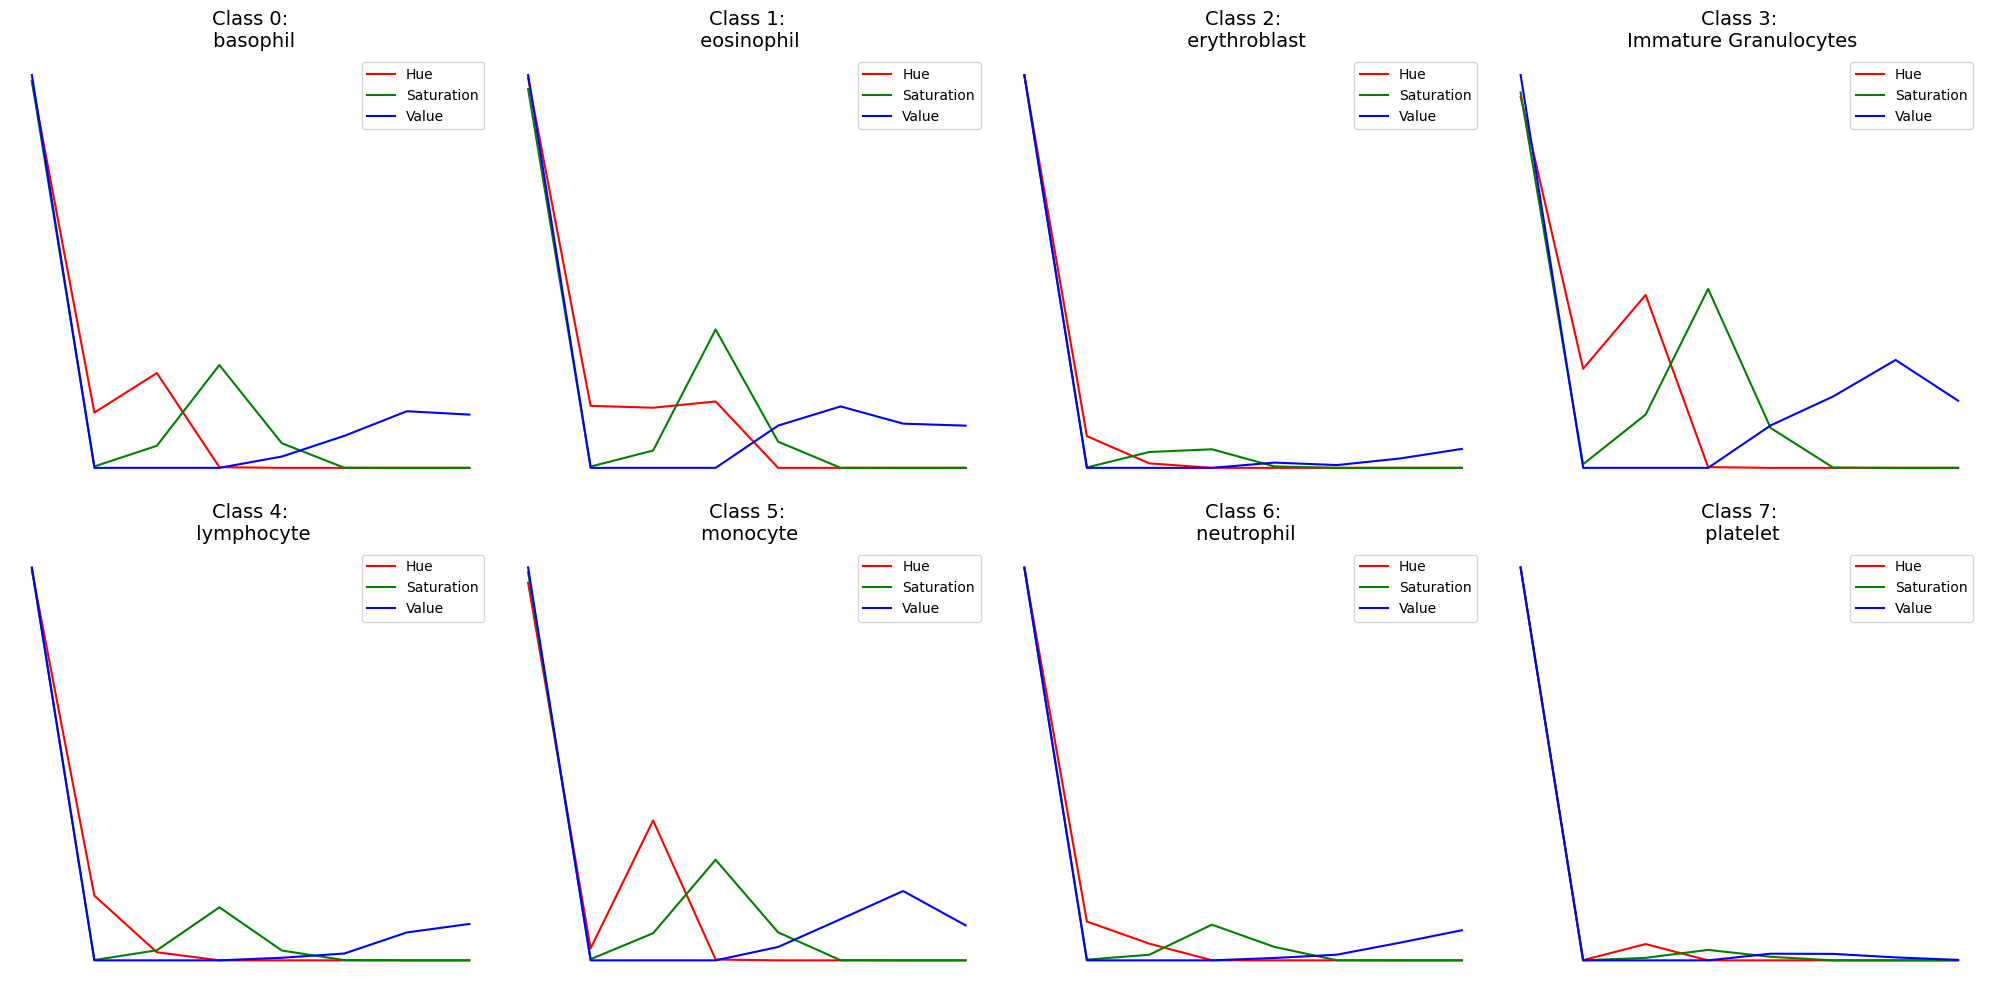

In [30]:
def show_color_histograms(dataset, n_classes, class_labels, bins=(8, 8, 8)):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            hsv = cv2.cvtColor((random_img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)

            # Compute the histograms for each channel
            hist_hue = cv2.calcHist([hsv], [0], None, [bins[0]], [0, 180])
            hist_saturation = cv2.calcHist([hsv], [1], None, [bins[1]], [0, 256])
            hist_value = cv2.calcHist([hsv], [2], None, [bins[2]], [0, 256])

            # Normalize the histograms
            hist_hue = cv2.normalize(hist_hue, hist_hue).flatten()
            hist_saturation = cv2.normalize(hist_saturation, hist_saturation).flatten()
            hist_value = cv2.normalize(hist_value, hist_value).flatten()

            # Plot histograms
            axes[class_idx].plot(hist_hue, color='r', label='Hue')
            axes[class_idx].plot(hist_saturation, color='g', label='Saturation')
            axes[class_idx].plot(hist_value, color='b', label='Value')
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')
            axes[class_idx].legend()

    plt.tight_layout()
    plt.show()

# Show color histograms for each class
show_color_histograms(train_data_preprocessed, n_classes_blood, class_labels_blood)


## Colored Pixel Count

In [91]:
# Pickle path for the final result
pickle_path = os.path.join(PICKLE_DIR, 'stain_counts.pkl')

# Check if the pickled file exists
if os.path.exists(pickle_path):
    with open(pickle_path, 'rb') as f:
        stain_counts_df = pickle.load(f)
else:
    stain_counts_df = pd.DataFrame(columns = ['class', 'stained_cell_count'])

    # count the number of pixels in an image which are within the range of values to create stained cell purple color
    def count_stained_cell_pixs(new_im, red_range, gre_range, blu_range):
        im_size = new_im.shape

        r_min, r_max = red_range
        g_min, g_max = gre_range
        b_min, b_max = blu_range

        cell_pix_count = 0
        none_count = 0
        for i in range(im_size[0]):
            for j in range(im_size[1]):
                if (new_im[i, j, 0] >= r_min) & (new_im[i, j, 0] <= r_max):
                    if (new_im[i, j, 1] >= g_min) & (new_im[i, j, 1] <= g_max):
                        if (new_im[i, j, 2] >= b_min) & (new_im[i, j, 2] <= b_max):
                            cell_pix_count += 1
                else:
                    none_count += 1
        return cell_pix_count

    # define pixel value ranges to search
    # Dark purple pixels
    red_range_d = (66, 150)
    gre_range_d = (10, 66)
    blu_range_d = (123, 142)

    # Light purple pixels
    red_range_l = (151, 192)
    gre_range_l = (67, 154)
    blu_range_l = (143, 162)

    # iterate through training examples
    # dark purple pixel counts
    train_num = 11959 # number of training examples

    for i in range(train_num):
        im, label = train_data_preprocessed[i]

        cell_pix_count = count_stained_cell_pixs(np.array(im), red_range_d, gre_range_d, blu_range_d)
        class_label = "class" + str(label[0])
        stain_counts_df.loc[i] = [class_label, cell_pix_count]

    # light purple pixel counts
    light_counts = pd.Series()

    for i in range(train_num):
        im, label = train_data[i]

        cell_pix_count = count_stained_cell_pixs(np.array(im), red_range_l, gre_range_l, blu_range_l)
        light_counts.loc[i] = cell_pix_count

    stain_counts_df['light_stain_count'] = light_counts

    # Save the final result to a pickle file
    with open(pickle_path, 'wb') as f:
        pickle.dump(stain_counts_df, f)

print(stain_counts_df.head())

/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_48018/1058763107.py:54: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  light_counts = pd.Series()


    class  stained_cell_count  light_stain_count
0  class7                 782                427
1  class3                6188               3321
2  class6                2785               1778
3  class6                4575               3105
4  class7                 284                425


In [92]:
stain_counts_df

class  stained_cell_count  light_stain_count
0      class7                 782                427
1      class3                6188               3321
2      class6                2785               1778
3      class6                4575               3105
4      class7                 284                425
...       ...                 ...                ...
11954  class6                2713               1373
11955  class2                 243                765
11956  class1                3423               2217
11957  class6                3264               2656
11958  class4                3955               1808

[11959 rows x 3 columns]

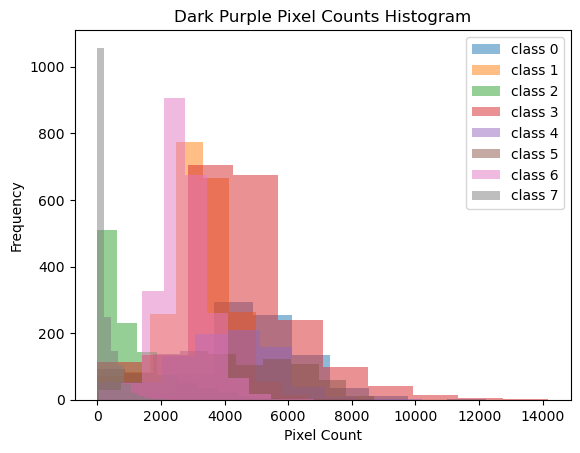

In [93]:
# dark purple stain histogram
cl_0_d = stain_counts_df[stain_counts_df['class']== 'class0']['stained_cell_count']
cl_1_d = stain_counts_df[stain_counts_df['class']== 'class1']['stained_cell_count']
cl_2_d = stain_counts_df[stain_counts_df['class']== 'class2']['stained_cell_count']
cl_3_d = stain_counts_df[stain_counts_df['class']== 'class3']['stained_cell_count']
cl_4_d = stain_counts_df[stain_counts_df['class']== 'class4']['stained_cell_count']
cl_5_d = stain_counts_df[stain_counts_df['class']== 'class5']['stained_cell_count']
cl_6_d = stain_counts_df[stain_counts_df['class']== 'class6']['stained_cell_count']
cl_7_d = stain_counts_df[stain_counts_df['class']== 'class7']['stained_cell_count']

plt.hist(cl_0_d,  alpha=0.5, label='class 0')
plt.hist(cl_1_d,  alpha=0.5, label='class 1')
plt.hist(cl_2_d,  alpha=0.5, label='class 2')
plt.hist(cl_3_d,  alpha=0.5, label='class 3')
plt.hist(cl_4_d,  alpha=0.5, label='class 4')
plt.hist(cl_5_d,  alpha=0.5, label='class 5')
plt.hist(cl_6_d,  alpha=0.5, label='class 6')
plt.hist(cl_7_d,  alpha=0.5, label='class 7')

plt.title('Dark Purple Pixel Counts Histogram')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

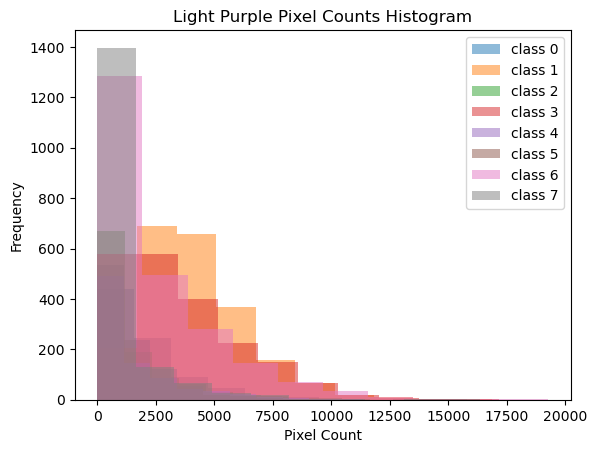

In [94]:
# light purple stain histogram
cl_0_l = stain_counts_df[stain_counts_df['class']== 'class0']['light_stain_count']
cl_1_l = stain_counts_df[stain_counts_df['class']== 'class1']['light_stain_count']
cl_2_l = stain_counts_df[stain_counts_df['class']== 'class2']['light_stain_count']
cl_3_l = stain_counts_df[stain_counts_df['class']== 'class3']['light_stain_count']
cl_4_l = stain_counts_df[stain_counts_df['class']== 'class4']['light_stain_count']
cl_5_l = stain_counts_df[stain_counts_df['class']== 'class5']['light_stain_count']
cl_6_l = stain_counts_df[stain_counts_df['class']== 'class6']['light_stain_count']
cl_7_l = stain_counts_df[stain_counts_df['class']== 'class7']['light_stain_count']

plt.hist(cl_0_l,  alpha=0.5, label='class 0')
plt.hist(cl_1_l,  alpha=0.5, label='class 1')
plt.hist(cl_2_l,  alpha=0.5, label='class 2')
plt.hist(cl_3_l,  alpha=0.5, label='class 3')
plt.hist(cl_4_l,  alpha=0.5, label='class 4')
plt.hist(cl_5_l,  alpha=0.5, label='class 5')
plt.hist(cl_6_l,  alpha=0.5, label='class 6')
plt.hist(cl_7_l,  alpha=0.5, label='class 7')

plt.title('Light Purple Pixel Counts Histogram')
plt.xlabel('Pixel Count')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [95]:
# averages of values by class w/ ratio of dark to light pixel counts
averages_df  = pd.DataFrame(columns = ['class', 'dark_stain_avg', 'light_stain_avg', 'ratio'])

averages_df.loc[0] = ['class0', cl_0_d.mean(), cl_0_l.mean(), cl_0_d.mean()/cl_0_l.mean()]
averages_df.loc[1] = ['class1', cl_1_d.mean(), cl_1_l.mean(), cl_1_d.mean()/cl_1_l.mean()]
averages_df.loc[2] = ['class2', cl_2_d.mean(), cl_2_l.mean(), cl_2_d.mean()/cl_2_l.mean()]
averages_df.loc[3] = ['class3', cl_3_d.mean(), cl_3_l.mean(), cl_3_d.mean()/cl_3_l.mean()]
averages_df.loc[4] = ['class4', cl_4_d.mean(), cl_4_l.mean(), cl_4_d.mean()/cl_4_l.mean()]
averages_df.loc[5] = ['class5', cl_5_d.mean(), cl_5_l.mean(), cl_5_d.mean()/cl_5_l.mean()]
averages_df.loc[6] = ['class6', cl_6_d.mean(), cl_6_l.mean(), cl_6_d.mean()/cl_6_l.mean()]
averages_df.loc[7] = ['class7', cl_7_d.mean(), cl_7_l.mean(), cl_7_d.mean()/cl_7_l.mean()]


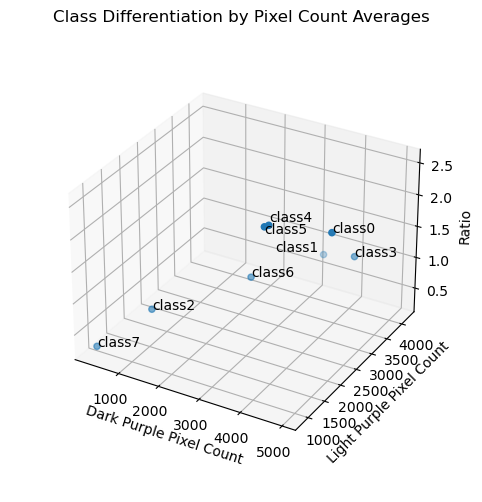

In [96]:
# scatterplot on 3d axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.scatter(averages_df['dark_stain_avg'], averages_df['light_stain_avg'], averages_df['ratio'])

# class_labels = stain_counts_df['class']
# for i in range(len(class_labels)):
#     ax.annotate(class_labels[i], (averages_df.loc[i]['dark_stain_avg'], averages_df.loc[i]['light_stain_avg'], averages_df.loc[i]['ratio']))

# for i in averages_df.index:
ax.text(averages_df.loc[0]['dark_stain_avg'], averages_df.loc[0]['light_stain_avg'], averages_df.loc[0]['ratio'], averages_df.loc[0]['class'])
ax.text(averages_df.loc[1]['dark_stain_avg']-1000, averages_df.loc[1]['light_stain_avg']-300, averages_df.loc[1]['ratio'], averages_df.loc[1]['class'])
ax.text(averages_df.loc[2]['dark_stain_avg'], averages_df.loc[2]['light_stain_avg'], averages_df.loc[2]['ratio'], averages_df.loc[2]['class'])
ax.text(averages_df.loc[3]['dark_stain_avg'], averages_df.loc[3]['light_stain_avg'], averages_df.loc[3]['ratio'], averages_df.loc[3]['class'])
ax.text(averages_df.loc[4]['dark_stain_avg'], averages_df.loc[4]['light_stain_avg'], averages_df.loc[4]['ratio']+0.05, averages_df.loc[4]['class'])
ax.text(averages_df.loc[5]['dark_stain_avg'], averages_df.loc[5]['light_stain_avg'], averages_df.loc[5]['ratio']-0.1, averages_df.loc[5]['class'])
ax.text(averages_df.loc[6]['dark_stain_avg'], averages_df.loc[6]['light_stain_avg'], averages_df.loc[6]['ratio'], averages_df.loc[6]['class'])
ax.text(averages_df.loc[7]['dark_stain_avg'], averages_df.loc[7]['light_stain_avg'], averages_df.loc[7]['ratio'], averages_df.loc[7]['class'])

ax.set_title('Class Differentiation by Pixel Count Averages')
ax.set_xlabel('Dark Purple Pixel Count')
ax.set_ylabel('Light Purple Pixel Count')
ax.set_zlabel('Ratio')
ax.set_box_aspect(aspect=None, zoom=0.85)
plt.show()

## Edge Detection & PCA

In [31]:
# # Create feature vectors using the specified features
# # Run once then comment out and run pickle.load below

# X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_edge_features])
# X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_edge_features])
# X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_edge_features])

# # Save the feature vectors and labels to disk
# with open('pickle/X_train_edge.pkl', 'wb') as f:
#     pickle.dump(X_train, f)
# with open('pickle/y_train_edge.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('pickle/X_val_edge.pkl', 'wb') as f:
#     pickle.dump(X_val, f)
# with open('pickle/y_val_edge.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# with open('pickle/X_test_edge.pkl', 'wb') as f:
#     pickle.dump(X_test, f)
# with open('pickle/y_test_edge.pkl', 'wb') as f:
#     pickle.dump(y_test, f)


In [32]:
with open('pickle/X_train_edge.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('pickle/y_train_edge.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('pickle/X_val_edge.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('pickle/y_val_edge.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('pickle/X_test_edge.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('pickle/y_test_edge.pkl', 'rb') as f:
    y_test = pickle.load(f)

In [33]:
# # Apply PCA to reduce dimensionality
# # Run once then comment out and run pickle.load below
# n_components = 100  # Adjust based on trade-off between speed and explained variance
# pca = PCA(n_components=n_components)
# X_train_pca = pca.fit_transform(X_train)
# X_val_pca = pca.transform(X_val)
# X_test_pca = pca.transform(X_test)

# # Save the PCA object and transformed feature vectors to disk
# with open('pickle/pca.pkl', 'wb') as f:
#     pickle.dump(pca, f)
# with open('pickle/X_train_edge_pca.pkl', 'wb') as f:
#     pickle.dump(X_train_pca, f)
# with open('pickle/X_val_edge_pca.pkl', 'wb') as f:
#     pickle.dump(X_val_pca, f)
# with open('pickle/X_test_edge_pca.pkl', 'wb') as f:
#     pickle.dump(X_test_pca, f)

In [34]:
n_components = 100  # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)

with open('pickle/pca.pkl', 'rb') as f:
    pca = pickle.load(f)
with open('pickle/X_train_edge_pca.pkl', 'rb') as f:
    X_train_pca = pickle.load(f)
with open('pickle/X_val_edge_pca.pkl', 'rb') as f:
    X_val_pca = pickle.load(f)
with open('pickle/X_test_edge_pca.pkl', 'rb') as f:
    X_test_pca = pickle.load(f)

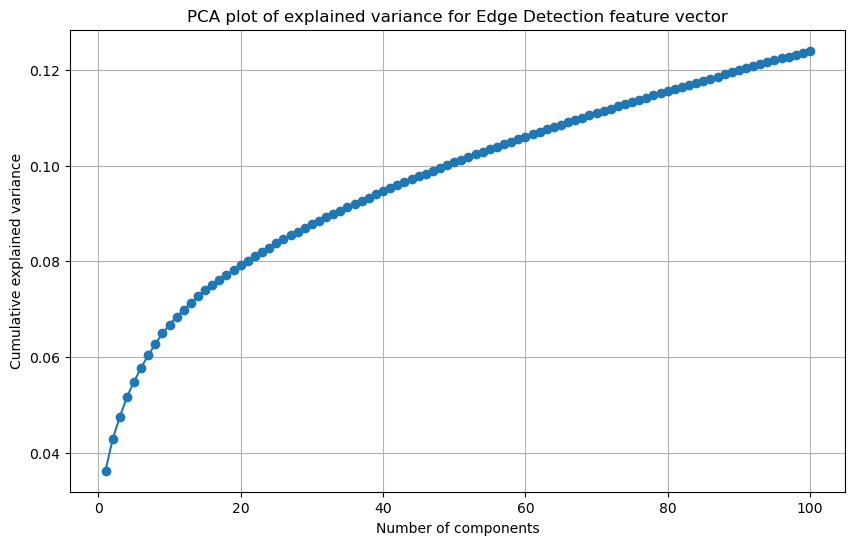

In [35]:
# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for Edge Detection feature vector')
plt.grid(True)
plt.show()

## Color Histograms and PCA

In [36]:
X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_color_histogram])
X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_color_histogram])
X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_color_histogram])

# Apply PCA to reduce dimensionality
n_components = 25  # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

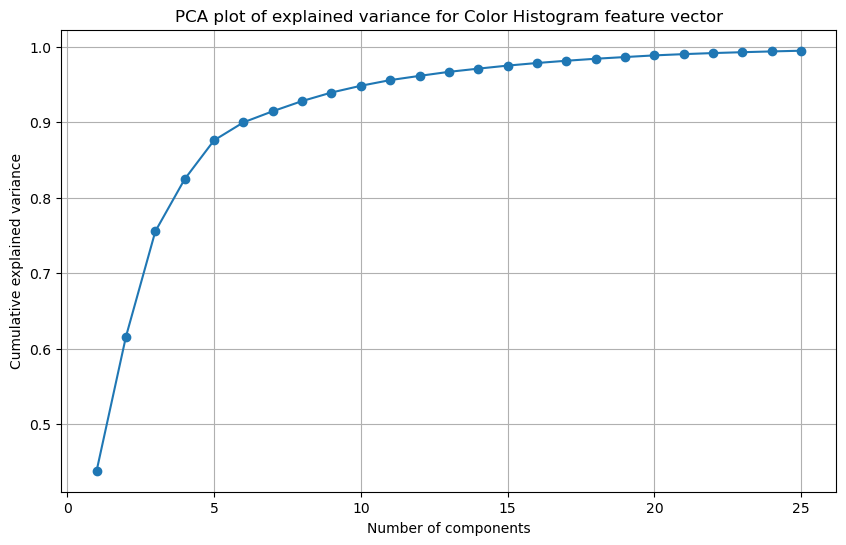

In [37]:
# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for Color Histogram feature vector')
plt.grid(True)
plt.show()

## Histogram of Oriented Gradients and PCA

In [38]:
def extract_hog_features(image):
    # Convert to grayscale
    gray_image = rgb2gray(image)

    features = hog(
        gray_image,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        visualize=False
    )
    return features

In [39]:
# # Run once then comment out and run pickle.load below

# X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_hog_features])
# X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_hog_features])
# X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_hog_features])

# # Save the feature vectors and labels to disk
# with open('pickle/X_train_hog.pkl', 'wb') as f:
#     pickle.dump(X_train, f)
# with open('pickle/y_train_hog.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('pickle/X_val_hog.pkl', 'wb') as f:
#     pickle.dump(X_val, f)
# with open('pickle/y_val_hog.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# with open('pickle/X_test_hog.pkl', 'wb') as f:
#     pickle.dump(X_test, f)
# with open('pickle/y_test_hog.pkl', 'wb') as f:
#     pickle.dump(y_test, f)


In [40]:
with open('pickle/X_train_hog.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('pickle/y_train_hog.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('pickle/X_val_hog.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('pickle/y_val_hog.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('pickle/X_test_hog.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('pickle/y_test_hog.pkl', 'rb') as f:
    y_test = pickle.load(f)

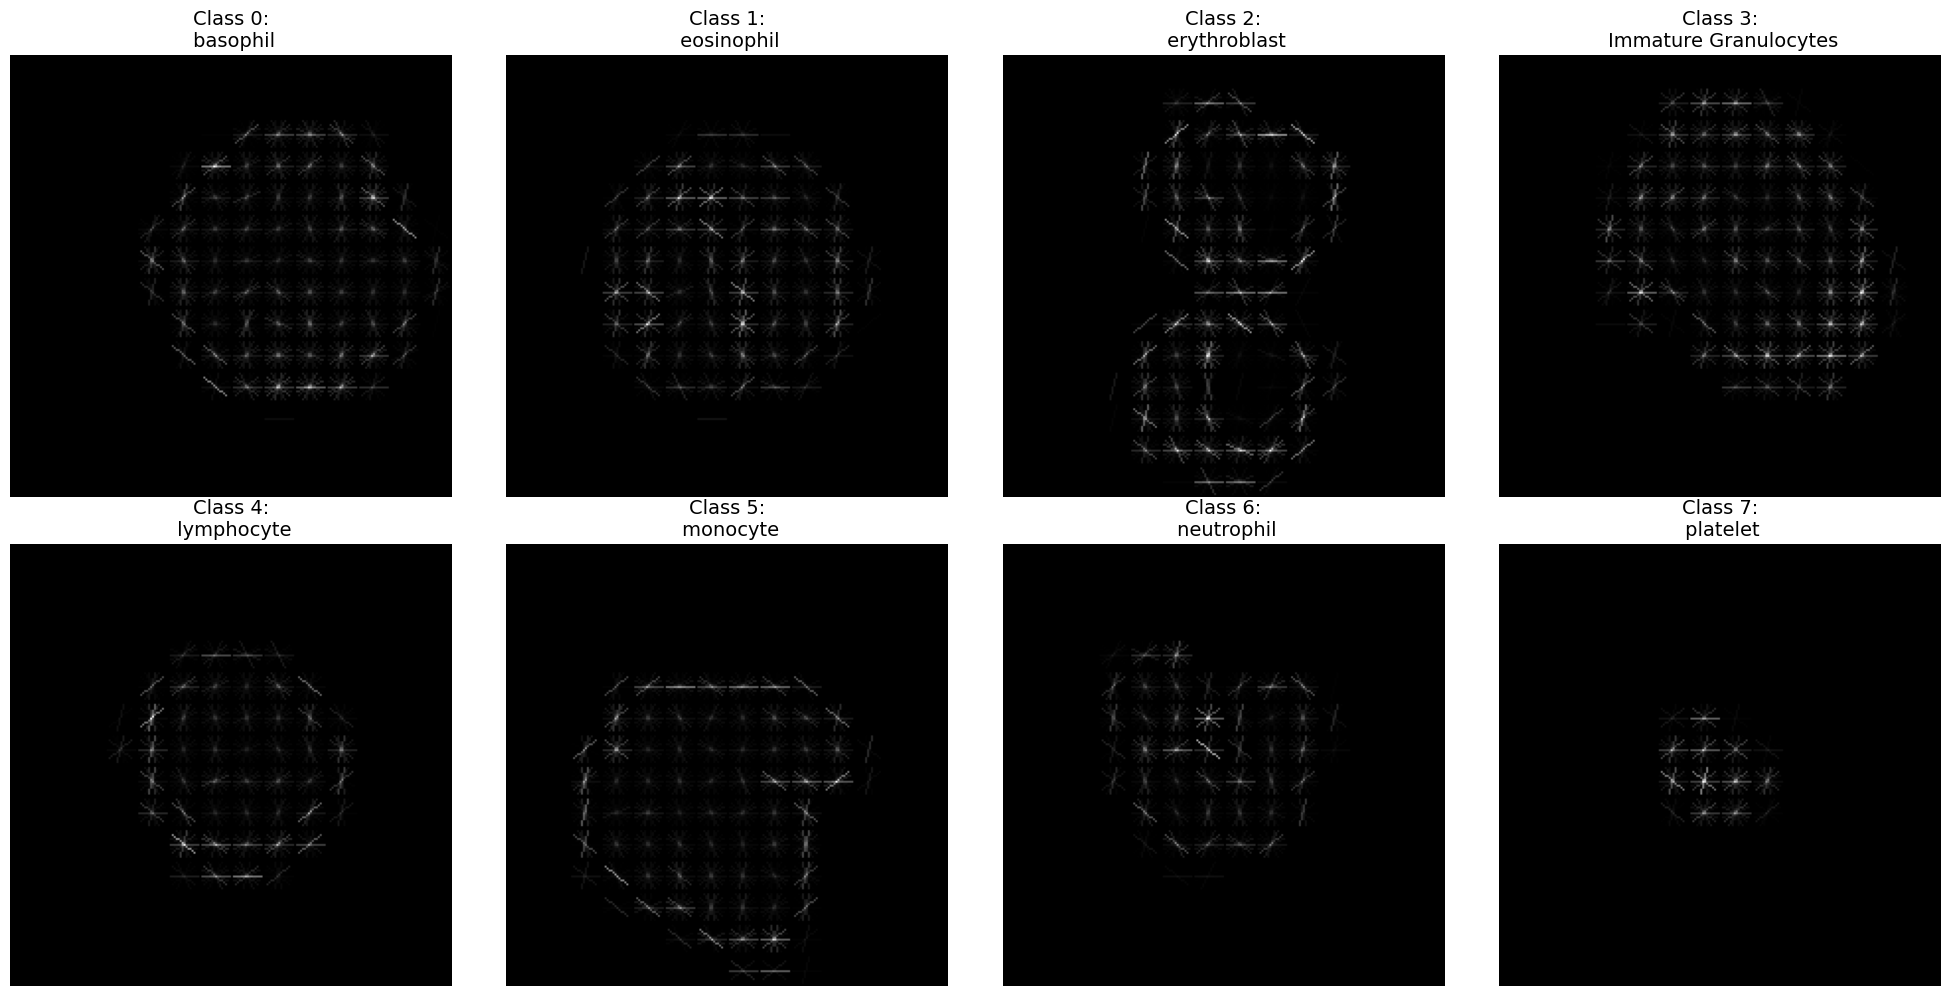

In [41]:
def show_hog_images_by_class(dataset, n_classes, class_labels):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    class_found = [False] * n_classes

    # Create a dictionary to store images by class
    class_images = {i: [] for i in range(n_classes)}
    for img, label in dataset:
        label = int(label)
        class_images[label].append(img)

    for class_idx in range(n_classes):
        if class_images[class_idx]:
            random_img = random.choice(class_images[class_idx])
            gray_img = rgb2gray(random_img)
            hog_features, hog_image = hog(gray_img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)

            # Plot HOG image
            axes[class_idx].imshow(hog_image, cmap='gray')
            axes[class_idx].set_title(f"Class {class_idx}:\n {class_labels[str(class_idx)]}", fontsize=14)
            axes[class_idx].axis('off')

    plt.tight_layout()
    plt.show()

# Show HOG images for each class
show_hog_images_by_class(train_data_preprocessed, n_classes_blood, class_labels_blood)

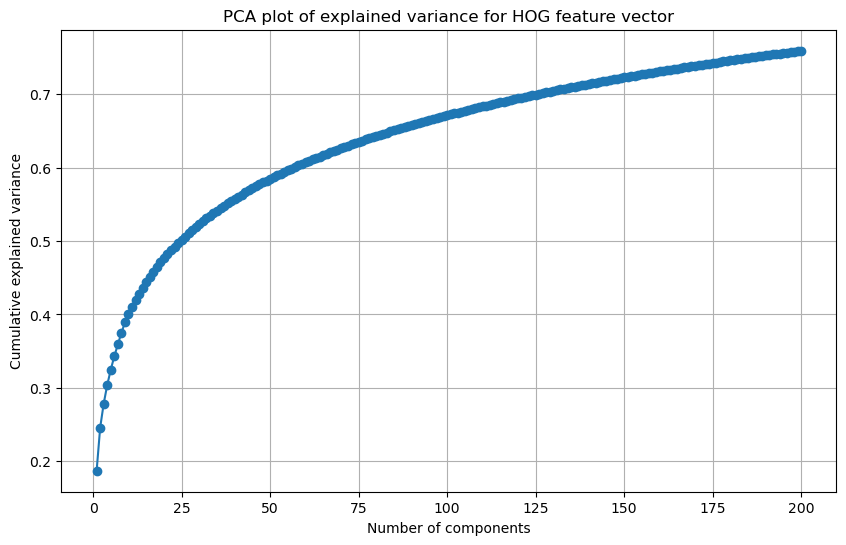

In [42]:
# Apply PCA to reduce dimensionality
n_components = 200 # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for HOG feature vector')
plt.grid(True)
plt.show()

## GLCM (Gray-Level Co-Occurrence Matrix) and PCA

In [43]:
# Function to extract GLCM features
def extract_glcm_features(image):
    # Ensure the image is 2D (grayscale)
    if image.ndim == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Compute the GLCM matrix
    distances = [1]  # Define distances for computing GLCM
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # Define angles for computing GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Compute GLCM properties
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    ASM = graycoprops(glcm, 'ASM').flatten()

    features = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, ASM])
    return features

In [44]:
# # Extract features from the preprocessed datasets using GLCM features
# # Run once then comment out and run pickle.load below
# X_train, y_train = create_feature_vectors(train_data_preprocessed, [extract_glcm_features])
# X_val, y_val = create_feature_vectors(val_data_preprocessed, [extract_glcm_features])
# X_test, y_test = create_feature_vectors(test_data_preprocessed, [extract_glcm_features])

# # Save the feature vectors and labels to disk
# with open('pickle/X_train_glcm.pkl', 'wb') as f:
#     pickle.dump(X_train, f)
# with open('pickle/y_train_glcm.pkl', 'wb') as f:
#     pickle.dump(y_train, f)
# with open('pickle/X_val_glcm.pkl', 'wb') as f:
#     pickle.dump(X_val, f)
# with open('pickle/y_val_glcm.pkl', 'wb') as f:
#     pickle.dump(y_val, f)
# with open('pickle/X_test_glcm.pkl', 'wb') as f:
#     pickle.dump(X_test, f)
# with open('pickle/y_test_glcm.pkl', 'wb') as f:
#     pickle.dump(y_test, f)

In [45]:
# Load the feature vectors and labels from disk
with open('pickle/X_train_glcm.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('pickle/y_train_glcm.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('pickle/X_val_glcm.pkl', 'rb') as f:
    X_val = pickle.load(f)
with open('pickle/y_val_glcm.pkl', 'rb') as f:
    y_val = pickle.load(f)
with open('pickle/X_test_glcm.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('pickle/y_test_glcm.pkl', 'rb') as f:
    y_test = pickle.load(f)

### GLCM features

**1. High dissimilarity** values indicate greater variation between neighboring pixel values, corresponding to a more complex texture. Low dissimilarity values indicate that pixel values are more uniform or similar, corresponding to a smoother texture.

**2. High homogeneity** values indicate that the image has many similar or identical pixel pairs, which correspond to a smooth or uniform texture. Low homogeneity values indicate that the pixel pairs are less similar, corresponding to a more complex texture.

**3. High energy values** indicate that the GLCM has high values for a few gray-level pairs, which means the texture is very uniform

**4. High correlation values** indicate that there is a strong linear relationship between the gray levels of pixel pairs, meaning that the texture has a regular and predictable pattern. Low correlation values indicate a weaker or no linear relationship, corresponding to a more random texture

**5. High ASM values** indicate that the texture is very regular and uniform. Low ASM values indicate a more disordered or complex texture.

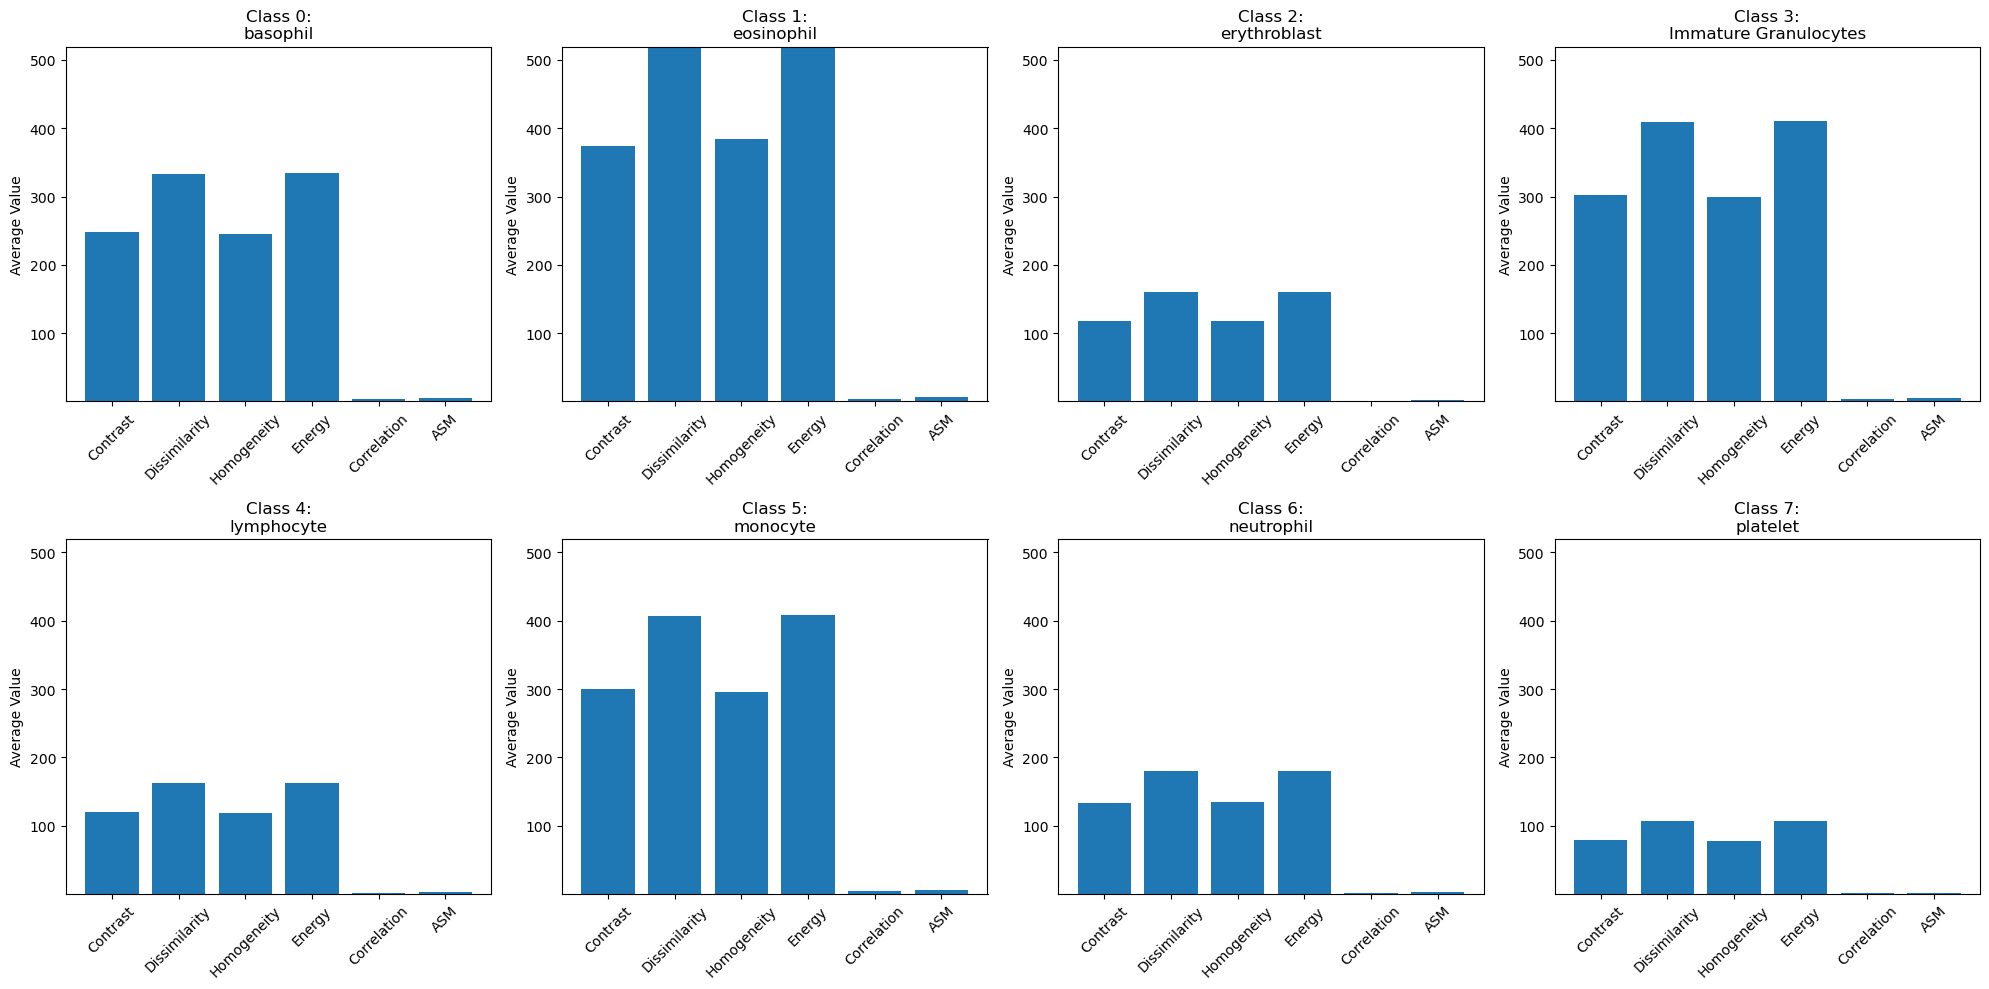

In [46]:
# Function to display GLCM features for each class

def show_glcm_features_by_class(X, y, n_classes, class_labels):
    features_by_class = {i: [] for i in range(n_classes)}

    # Aggregate features by class
    for features, label in zip(X, y):
        features_by_class[int(label)].append(features)

    # Calculate average features for each class
    avg_features_by_class = {class_idx: np.mean(features, axis=0) for class_idx, features in features_by_class.items()}

    # Determine the global min and max values for y-axis
    all_avg_features = np.array(list(avg_features_by_class.values()))
    y_min = np.min(all_avg_features[:, :6])
    y_max = np.max(all_avg_features[:, :6])

    # Plot the average features for each class
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()

    feature_names = ['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation', 'ASM']
    for class_idx, avg_features in avg_features_by_class.items():
        axes[class_idx].bar(feature_names, avg_features[:6])
        axes[class_idx].set_title(f"Class {class_idx}:\n{class_labels[str(class_idx)]}")
        axes[class_idx].set_ylim([y_min - 0.1, y_max + 0.1])
        axes[class_idx].set_ylabel('Average Value')
        axes[class_idx].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Get the class labels and the number of classes
blood_info = INFO['bloodmnist']
class_labels_blood = blood_info['label']
class_labels_blood['3'] = 'Immature Granulocytes'
n_classes_blood = len(class_labels_blood)

# Show GLCM features for each class
show_glcm_features_by_class(X_train, y_train, n_classes_blood, class_labels_blood)

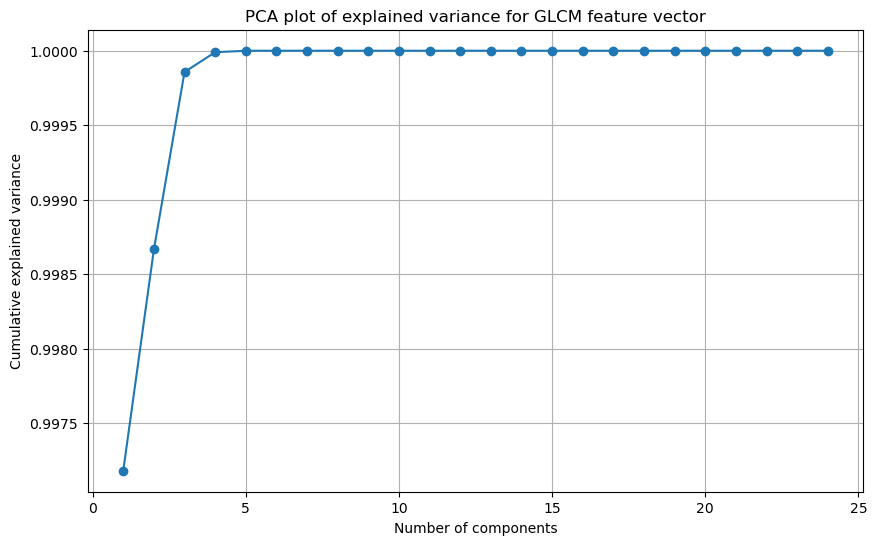

In [47]:
# Apply PCA to reduce dimensionality
n_components = min(X_train.shape[0], X_train.shape[1])  # Set to the minimum of samples and features
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for GLCM feature vector')
plt.grid(True)
plt.show()

## Visual Bag of Words and PCA

/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


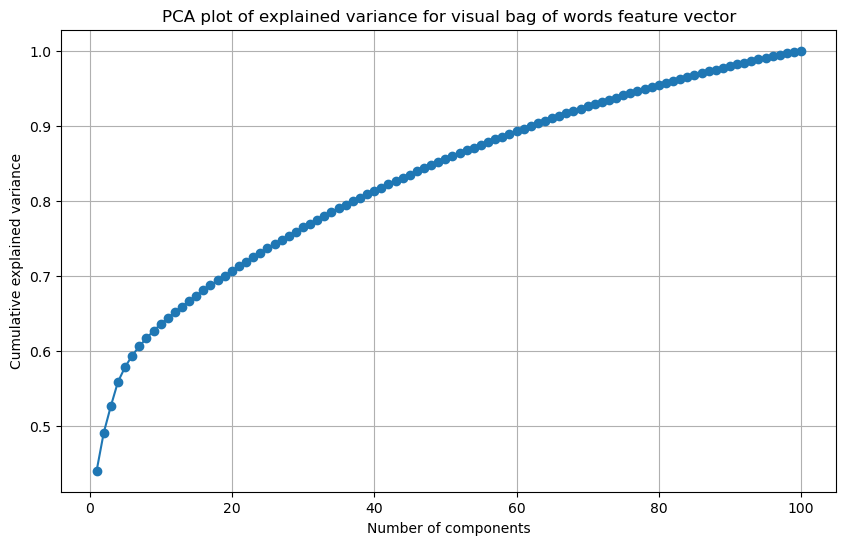

In [84]:
import os
import pickle
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Directories for pickling
os.makedirs(PICKLE_DIR, exist_ok=True)

# Function to extract SIFT features from an image
def extract_sift_features(image):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Function to create a visual vocabulary
def create_vocabulary(descriptors_list, vocab_size=100):
    kmeans = MiniBatchKMeans(n_clusters=vocab_size, random_state=0)
    kmeans.fit(descriptors_list)
    return kmeans

# Function to create histograms of visual words for each image
def create_histograms(vocabulary, descriptors_list):
    histograms = []
    for descriptors in descriptors_list:
        histogram, _ = np.histogram(vocabulary.predict(descriptors), bins=np.arange(vocabulary.n_clusters+1))
        histograms.append(histogram)
    return np.array(histograms)

def preprocess_for_bow(dataset):
    descriptors_list = []
    valid_images = []
    labels = []
    for img, label in dataset:
        gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
        descriptors = extract_sift_features(gray_img)
        if descriptors is not None:
            descriptors_list.append(descriptors)
            valid_images.append(img)
            labels.append(label)
    return descriptors_list, valid_images, np.array(labels)

# Load or preprocess the data for BoW
def load_or_preprocess_bow(dataset, pickle_path):
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as f:
            return pickle.load(f)
    else:
        descriptors_list, valid_images, labels = preprocess_for_bow(dataset)
        with open(pickle_path, 'wb') as f:
            pickle.dump((descriptors_list, valid_images, labels), f)
        return descriptors_list, valid_images, labels

# Paths to save the pickled BoW features
train_bow_path = os.path.join(PICKLE_DIR, 'train_bow.pkl')
val_bow_path = os.path.join(PICKLE_DIR, 'val_bow.pkl')
test_bow_path = os.path.join(PICKLE_DIR, 'test_bow.pkl')

# Load or preprocess the data
train_descriptors_list, train_valid_images, y_train = load_or_preprocess_bow(train_data_preprocessed, train_bow_path)
val_descriptors_list, val_valid_images, y_val = load_or_preprocess_bow(val_data_preprocessed, val_bow_path)
test_descriptors_list, test_valid_images, y_test = load_or_preprocess_bow(test_data_preprocessed, test_bow_path)

# Stack all descriptors for vocabulary creation
all_descriptors = np.vstack(train_descriptors_list)

# Create vocabulary
vocab_size = 100
vocabulary = create_vocabulary(all_descriptors, vocab_size=vocab_size)

# Create histograms for each dataset
X_train_bow = create_histograms(vocabulary, train_descriptors_list)
X_val_bow = create_histograms(vocabulary, val_descriptors_list)
X_test_bow = create_histograms(vocabulary, test_descriptors_list)

# Standardize the histograms
scaler = StandardScaler().fit(X_train_bow)
X_train_bow = scaler.transform(X_train_bow)
X_val_bow = scaler.transform(X_val_bow)
X_test_bow = scaler.transform(X_test_bow)

# Paths to save the pickled PCA features
train_pca_bow_path = os.path.join(PICKLE_DIR, 'train_pca_bow.pkl')
val_pca_bow_path = os.path.join(PICKLE_DIR, 'val_pca_bow.pkl')
test_pca_bow_path = os.path.join(PICKLE_DIR, 'test_pca_bow.pkl')

# Apply PCA to reduce dimensionality and pickle the results
def apply_pca_and_pickle(X_train, X_val, X_test, n_components, pca_path_train, pca_path_val, pca_path_test):
    pca = PCA(n_components=n_components)
    if os.path.exists(pca_path_train) and os.path.exists(pca_path_val) and os.path.exists(pca_path_test):
        with open(pca_path_train, 'rb') as f:
            X_train_pca = pickle.load(f)
        with open(pca_path_val, 'rb') as f:
            X_val_pca = pickle.load(f)
        with open(pca_path_test, 'rb') as f:
            X_test_pca = pickle.load(f)
        pca.fit(X_train)  # Fit PCA to the training data to get explained variance ratio
    else:
        n_components = min(n_components, X_train.shape[1])
        X_train_pca = pca.fit_transform(X_train)
        X_val_pca = pca.transform(X_val)
        X_test_pca = pca.transform(X_test)
        with open(pca_path_train, 'wb') as f:
            pickle.dump(X_train_pca, f)
        with open(pca_path_val, 'wb') as f:
            pickle.dump(X_val_pca, f)
        with open(pca_path_test, 'wb') as f:
            pickle.dump(X_test_pca, f)
    return X_train_pca, X_val_pca, X_test_pca, pca

# Apply PCA and save the results
n_components = 100  # Adjust based on trade-off between speed and explained variance
X_train_pca, X_val_pca, X_test_pca, pca = apply_pca_and_pickle(X_train_bow, X_val_bow, X_test_bow, n_components, train_pca_bow_path, val_pca_bow_path, test_pca_bow_path)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for visual bag of words feature vector')
plt.grid(True)
plt.show()


# Define Final Feature Vector

In [ ]:
# def create_feature_vectors(dataset, valid_images, feature_extractors, bow_histograms):
#     feature_vectors = []
#     labels = []
#     for i, (img, label) in enumerate(zip(valid_images, dataset)):
#         features = []
#         for extractor in feature_extractors:
#             features.extend(extractor(np.array(img)))
#         features.extend(bow_histograms[i])
#         feature_vectors.append(features)
#         labels.append(label)
#     return np.array(feature_vectors), np.array(labels)

In [69]:
def create_feature_vectors(dataset, feature_extractors):
    feature_vectors = []
    labels = []
    for img, label in dataset:
        features = []
        for extractor in feature_extractors:
            features.extend(extractor(np.array(img)))
        feature_vectors.append(features)
        labels.append(label)
    return np.array(feature_vectors), np.array(labels)

In [70]:
# Create final feature vectors including color histograms, HOG features, and GLCM features
X_train, y_train = create_feature_vectors(train_data_preprocessed, [
    extract_color_histogram,
    # extract_hog_features,
    extract_glcm_features
])

X_val, y_val = create_feature_vectors(val_data_preprocessed, [
    extract_color_histogram,
    # extract_hog_features,
    extract_glcm_features
])

X_test, y_test = create_feature_vectors(test_data_preprocessed, [
    extract_color_histogram,
    # extract_hog_features,
    extract_glcm_features
])

# Standardize the feature vectors
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [71]:
X_train.shape

(11959, 536)

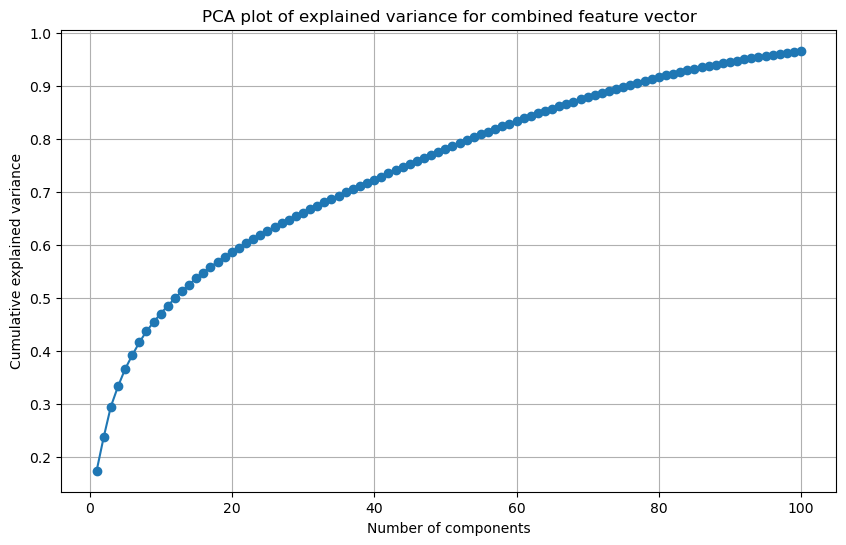

In [72]:
n_components = 100  # Adjust based on trade-off between speed and explained variance
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA plot of explained variance for combined feature vector')
plt.grid(True)
plt.show()

In [73]:
X_train_pca.shape

(11959, 100)

In [74]:
# # Create final feature vectors including color histograms, HOG features, GLCM features, and BoW histograms
# X_train, y_train = create_feature_vectors(train_data_preprocessed, train_valid_images,
#                                           [extract_color_histogram, extract_hog_features, extract_glcm_features], X_train_bow)

# X_val, y_val = create_feature_vectors(val_data_preprocessed, val_valid_images,
#                                       [extract_color_histogram, extract_hog_features, extract_glcm_features], X_val_bow)

# X_test, y_test = create_feature_vectors(test_data_preprocessed, test_valid_images,
#                                         [extract_color_histogram, extract_hog_features, extract_glcm_features], X_test_bow)

# # Apply PCA to reduce dimensionality
# n_components = 100  # Adjust based on trade-off between speed and explained variance
# pca = PCA(n_components=n_components)
# X_train_pca = pca.fit_transform(X_train)
# X_val_pca = pca.transform(X_val)
# X_test_pca = pca.transform(X_test)

# Build and Evaluate Models

In [75]:
def plot_confusion_matrix(y_true, y_pred, classes, title, cmap = 'Blues'):
    '''Function is used for plotting '''
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

## Logistic Regression (Baseline)

/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training accuracy: 0.9321013462664103
Validation accuracy: 0.9205607476635514
Test accuracy: 0.91581408944753
Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.91      0.92      0.91       244
           eosinophil       0.99      0.99      0.99       624
         erythroblast       0.92      0.91      0.91       311
Immature Granulocytes       0.83      0.78      0.81       579
           lymphocyte       0.91      0.94      0.93       243
             monocyte       0.80      0.81      0.80       284
           neutrophil       0.92      0.93      0.92       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.92      3421
            macro avg       0.91      0.91      0.91      3421
         weighted avg       0.92      0.92      0.92      3421



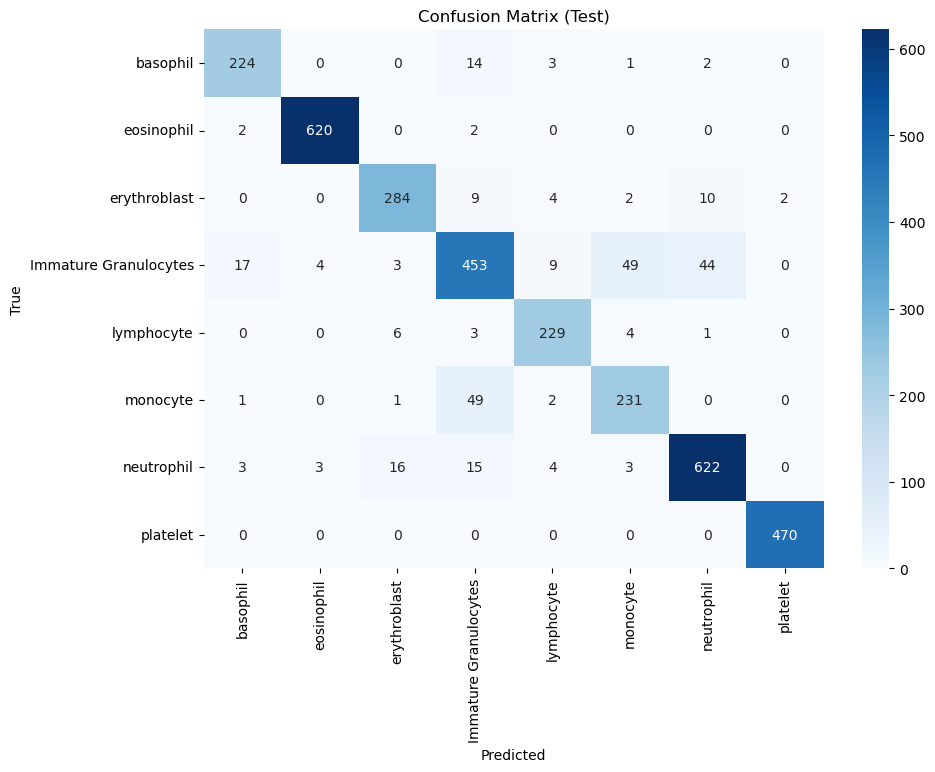

In [76]:
# Train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_pca, y_train)

# Evaluate the model
y_train_pred = log_reg.predict(X_train_pca)
y_val_pred = log_reg.predict(X_val_pca)
y_test_pred = log_reg.predict(X_test_pca)

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

# Plot confusion matrix for test data
plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test) From Logistic Regression')

## Random Forest

/var/folders/lh/xjdvj6w17sb4ymqrg_4w1yfw0000gp/T/ipykernel_48018/2739449260.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train_pca, y_train)


Training accuracy: 0.9999163809683084
Validation accuracy: 0.915303738317757
Test accuracy: 0.9082139725226542
Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.89      0.84      0.87       244
           eosinophil       0.99      0.98      0.98       624
         erythroblast       0.92      0.86      0.89       311
Immature Granulocytes       0.77      0.84      0.80       579
           lymphocyte       0.94      0.91      0.93       243
             monocyte       0.87      0.81      0.84       284
           neutrophil       0.91      0.92      0.92       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.91      3421
            macro avg       0.91      0.90      0.90      3421
         weighted avg       0.91      0.91      0.91      3421



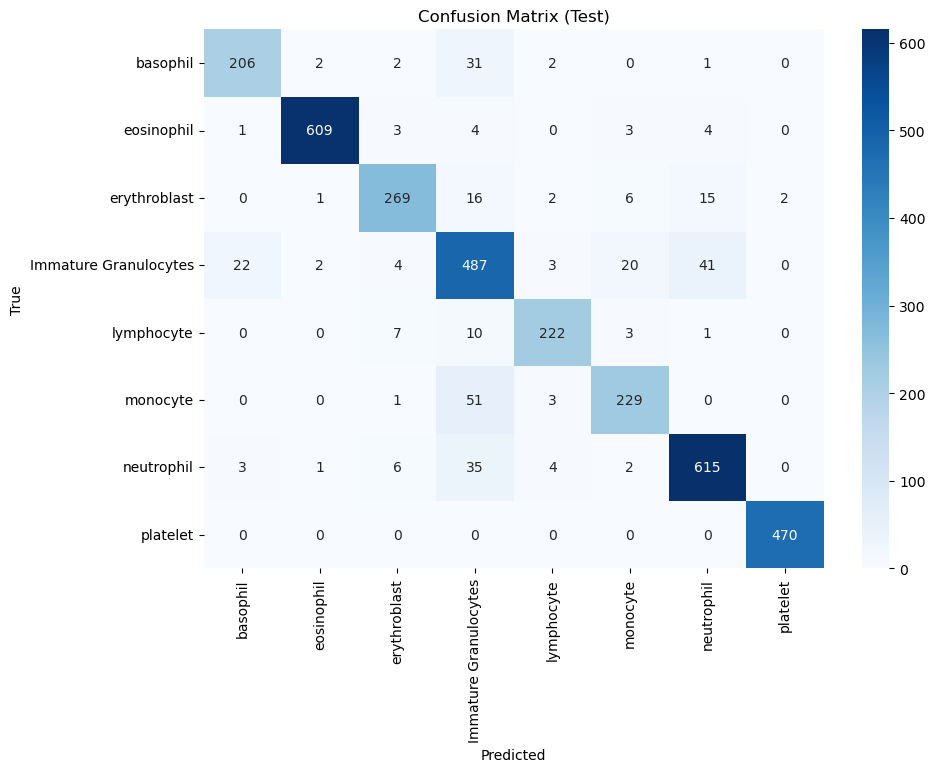

In [77]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# Evaluate the model
y_train_pred = rf_model.predict(X_train_pca)
y_val_pred = rf_model.predict(X_val_pca)
y_test_pred = rf_model.predict(X_test_pca)

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test) From Random Forest')

## XGBoost

Training accuracy: 0.9999163809683084
Validation accuracy: 0.9392523364485982
Test accuracy: 0.9321835720549547
Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.90      0.86      0.88       244
           eosinophil       1.00      0.99      0.99       624
         erythroblast       0.95      0.91      0.93       311
Immature Granulocytes       0.84      0.85      0.85       579
           lymphocyte       0.95      0.95      0.95       243
             monocyte       0.89      0.89      0.89       284
           neutrophil       0.93      0.95      0.94       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.93      3421
            macro avg       0.93      0.93      0.93      3421
         weighted avg       0.93      0.93      0.93      3421



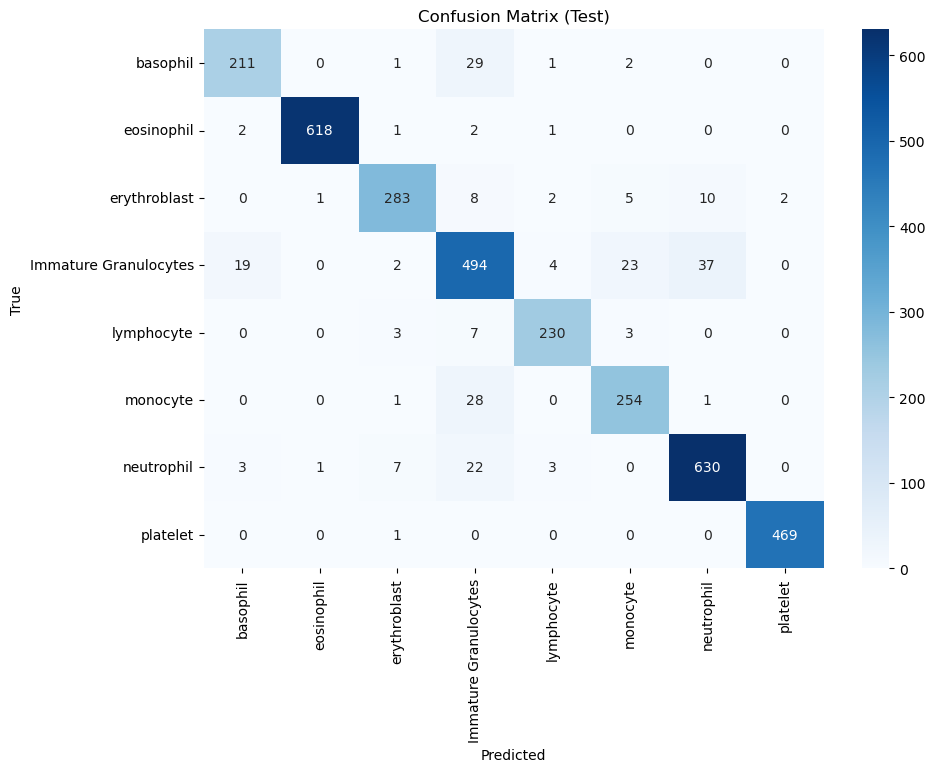

In [78]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_pca, y_train)

# Evaluate the model
y_train_pred = xgb_model.predict(X_train_pca)
y_val_pred = xgb_model.predict(X_val_pca)
y_test_pred = xgb_model.predict(X_test_pca)

print("Training accuracy:", accuracy_score(y_train, y_train_pred))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test) From XGBoost')

## Support Vector Machines

### SVM (Linear)

/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Linear SVM
Training accuracy: 0.8821807843465173
Validation accuracy: 0.866822429906542
Test accuracy: 0.87284419760304
Classification report (Test):
                       precision    recall  f1-score   support

             basophil       0.82      0.94      0.87       244
           eosinophil       0.98      0.99      0.99       624
         erythroblast       0.88      0.94      0.91       311
Immature Granulocytes       0.77      0.54      0.63       579
           lymphocyte       0.91      0.94      0.92       243
             monocyte       0.64      0.81      0.71       284
           neutrophil       0.88      0.91      0.89       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.87      3421
            macro avg       0.86      0.88      0.87      3421
         weighted avg       0.87      0.87      0.87      3421



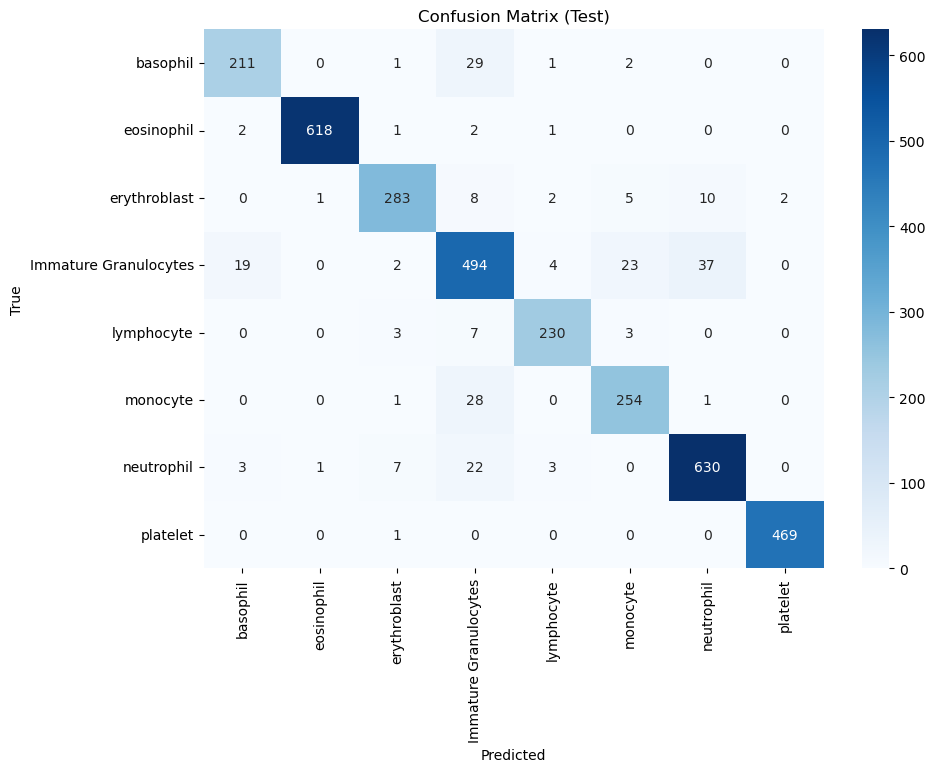

In [79]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Train and evaluate linear SVM model
linear_svm = SVC(kernel='linear', max_iter=1000)
linear_svm.fit(X_train_pca, y_train)

# Predictions for linear SVM
y_train_pred_linear = linear_svm.predict(X_train_pca)
y_val_pred_linear = linear_svm.predict(X_val_pca)
y_test_pred_linear = linear_svm.predict(X_test_pca)

print("Linear SVM")
print("Training accuracy:", accuracy_score(y_train, y_train_pred_linear))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred_linear))
print("Test accuracy:", accuracy_score(y_test, y_test_pred_linear))
print("Classification report (Test):")
print(classification_report(y_test, y_test_pred_linear, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Confusion Matrix (Test) From Linear SVM')

### SVM (RBF - Radian Basis Function)

/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lowi33/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RBF SVM
Training accuracy: 0.9409649636257212
Validation accuracy: 0.9228971962616822
Test accuracy: 0.9213680210464776
Classification report (Test) From SVM - RBF:
                       precision    recall  f1-score   support

             basophil       0.91      0.87      0.89       244
           eosinophil       1.00      0.96      0.98       624
         erythroblast       0.84      0.93      0.88       311
Immature Granulocytes       0.85      0.83      0.84       579
           lymphocyte       0.95      0.93      0.94       243
             monocyte       0.89      0.87      0.88       284
           neutrophil       0.92      0.94      0.93       666
             platelet       1.00      1.00      1.00       470

             accuracy                           0.92      3421
            macro avg       0.92      0.92      0.92      3421
         weighted avg       0.92      0.92      0.92      3421



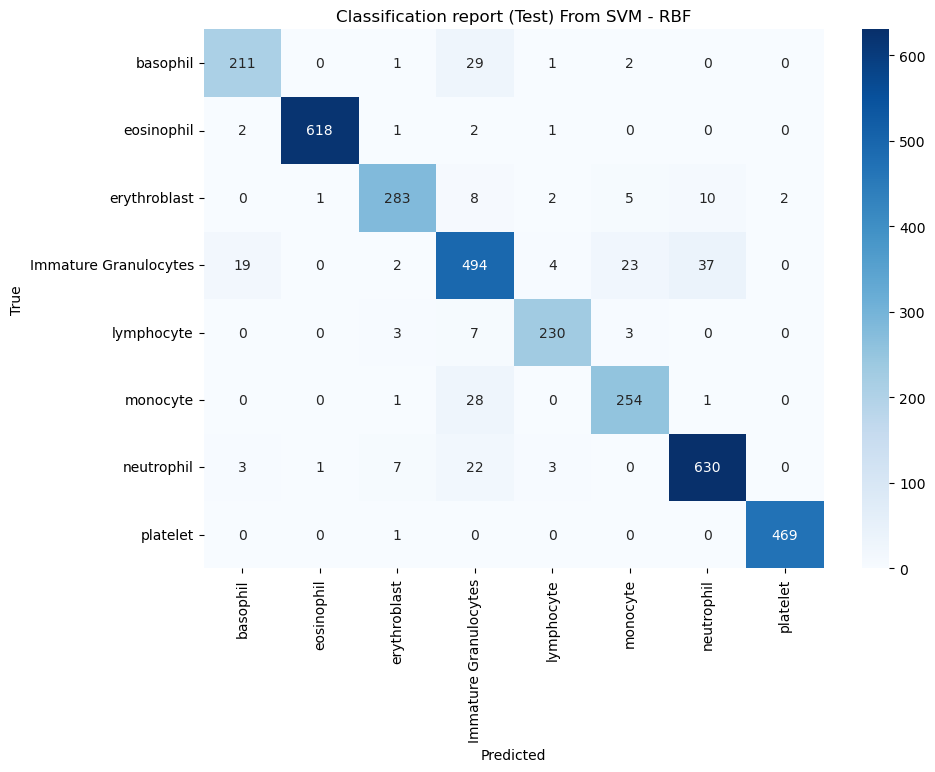

In [82]:
# Train and evaluate RBF SVM model
rbf_svm = SVC(kernel='rbf', max_iter=1000)
rbf_svm.fit(X_train_pca, y_train)

# Predictions for RBF SVM
y_train_pred_rbf = rbf_svm.predict(X_train_pca)
y_val_pred_rbf = rbf_svm.predict(X_val_pca)
y_test_pred_rbf = rbf_svm.predict(X_test_pca)

print("RBF SVM")
print("Training accuracy:", accuracy_score(y_train, y_train_pred_rbf))
print("Validation accuracy:", accuracy_score(y_val, y_val_pred_rbf))
print("Test accuracy:", accuracy_score(y_test, y_test_pred_rbf))
print("Classification report (Test) From SVM - RBF:")
print(classification_report(y_test, y_test_pred_rbf, target_names=[class_labels_blood[str(i)] for i in range(n_classes_blood)]))

plot_confusion_matrix(y_test, y_test_pred, [class_labels_blood[str(i)] for i in range(n_classes_blood)], 'Classification report (Test) From SVM - RBF')